# Exploring the relationship between poverty, educational attainment and underage pregnancy in London

# Introduction

## Research topic

The UK has a relatively high rate of teenage pregnancies compared to the rest of Europe [1]. In 1999, the UK government introduced a 10-year teenage pregnancy strategy for England. Since then, the UK has continued to develop their teenage pregnancy framework to reduce the rate of underage conceptions [2]. 

There are many factors which put a young person at risk of becoming pregnant under the age of 18. These factors include socioeconomic status, being the child of a teenage mother, peer pressure to participate in sexual behaviours, alcohol consumption, poor school attendance and performance, and lack of sexual health knowledge [3].

I explore the correlation between poverty, educational attainment, and underage conception rates in London between 1998 and 2019. I look at poverty and educational attainment together as children who live in poverty or come from a low socioeconomic background tend to be disadvantaged in education [4]. 

As members of the public do not have access to protected data (i.e. data about individuals), I use data aggregated by borough. Boroughs are small enough areas to allow us to see relationships and trends, but are large enough that data is not supressed (underage conceptions by electoral ward are not published as a large proportion of the data would have to be supressed). 

There is a large scope of literature examining which factors are linked to teenage pregnancy - the aim of the project is to see if we can identify trends and correlations in data aggregated by spatial area. The use cases of such an analysis includes linking trends over time with the policies and schemes of different areas to identify the most effective way to reduce underage conception rates at an administrative level.

## Research questions

I explore the following research questions:

1. How have underage conception rates varied in London from 1998 to 2019?
2. How have child poverty rates in London changed between 2006 and 2016? Are child poverty rates in boroughs correlated with underage conceptions? Socioeconomic disadvantage/poverty has been identified as a risk factor for teenage pregnancy [3][5].
3. How have rates of female GCSE pupils eligible for free school meals in London changed between 2009 and 2020? Are free school meals eligibility rates for girls in boroughs correlated with underage conceptions? Public Health England have identified free school meals eligibility as a risk factor for underage pregnancy, as it is a poverty indicator [2].
5. How has girls' GCSE attainment in London changed between 2009 and 2020? Is girls' average GCSE attainment in boroughs correlated with underage conception? Is the average GCSE attainment of girls eligible for free school meals correlated with underage conception? Low educational attainment has been identified as a risk factor for teenage pregnancy [2][3][5].

## Data sources

All data was downloaded from the London Datastore as Excel spreadsheets, and is owned by government departments. UK government civil servants follow the Government Data Quality Framework [6], meaning we can generally expect high quality data from the UK government.

Data used within this report, source/owner, and any notes regarding/limitations of the data:

* **Teenage Conceptions by Borough** - Office for National Statistics (ONS)
    * The ONS compiles conception statistics by using birth and stillbirth records collected under the Births and Deaths Registration Act 1953 and abortion records collected under the Abortion Act 1967 [7]. Miscarriages and illegal abortions are not included in the conception rates, meaning published conception rates are an underestimation of true conception rates. 
    * City of London figures have been combined with Hackney.
    * Both Under 18 and Under 16 conception rates are published. Under 18 rates are for girls aged 15-17. Under 16 rates are for girls aged 13-15. These could not be combined as 15 year olds would be double counted. Therefore I have chosen to look at those aged 15-17 only.
* **ONS Mid-year Population Estimates by Borough, Year, Gender and Age** - compiled by the Greater London Authority (GLA) using ONS data
    * Methodology for estimating populations is complex and will not be described in detail here. However, a May 2021 review found that the ONS 'use internationally recognised methods and sources as the basis for population estimates and projections that are fit for purpose' [8]. 
* **Children in Poverty by Borough and Year** - HM Revenue & Customs
    * We will use percentage of children in "poverty", denoted by the Children in Low-Income Families Local Measure which captures 'proportion of children living in families in receipt of out-of-work (means-tested) benefits or in receipt of tax credits where their reported income is less than 60 per cent of UK median income'. This measure is used by HMRC as an approximation of relative low income child poverty (as defined by the Child Poverty Act 2010) [9].
* **GCSE Results by Free School Meal Eligibility, Borough and Gender** - Department for Education
    * In the 2015/16 academic year, a the new 1-9 GCSE grading system replaced the old A\*-G system. The two systems cannot be directly compared. The old system metric of attainment (for each borough) is percentage of pupils achieving 5+ A\*-C grades, whereas the new system metric is average Attainment 8 score.
    * Results are for the end of Key Stage 4, when students are 15/16. This aligns with the population for underage conceptions (15-17) - during GCSEs or shortly afterwards.
    
Maps of London use digital boundaries and reference maps supplied under the Open Government Licence and Ordnance Survey OpenData Licence.
* Contains National Statistics data © Crown copyright and database right 2012
* Contains Ordnance Survey data © Crown copyright and database right 2012

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import ticker
import geopandas as gpd
import time
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button
from matplotlib.animation import FuncAnimation
import re
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

# Data pre-processing

## Underage conceptions

The data is in a spreadsheet but is not in an ideal format for analysis. Below, data is reshaped, location (inner/outer London) is added, dtypes are defined so variables can be plotted correctly, and approximate population is calculated to allow us to calculate a correct rate when data is aggregated.

In [3]:
# Underage conceptions by borough
ucb = pd.read_excel('Data/teenage-conceptions-borough.xls', sheet_name='Under18 1998-2019', 
                   skiprows=[2], nrows=32, header = [0, 1], index_col=[0,1])

# As pandas does not let us usecols when specifying a multi-index header, along with other limitations, we will
# clean up the dataframe after import
ucb = ucb.drop(['% leading to abortion', ' % leading to abortion'], axis=1, level=1)
ucb = ucb.droplevel(0, axis=0)
ucb.index.names = ['Borough']
ucb.columns.names = ['Year', None]
ucb = ucb.stack(0)

# Spreadsheet did not define whether boroughs were inner or outer London, add into multiindex
inner_london_bors = ['Camden', 'Hackney and City of London', 'Hammersmith and Fulham', 'Haringey', 'Islington', 
                'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Newham', 'Southwark', 'Tower Hamlets', 
                'Wandsworth', 'Westminster']
outer_london_bors = ['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Croydon', 'Ealing', 'Enfield', 
                'Greenwich', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Kingston upon Thames', 'Merton', 
                'Redbridge', 'Richmond upon Thames', 'Sutton', 'Waltham Forest']

for b in ucb.index:
    if b[0] in inner_london_bors:
        ucb.loc[b, 'Location'] = 'Inner London'
    elif b[0] in outer_london_bors:
        ucb.loc[b, 'Location'] = 'Outer London'
    else:
        print(b, 'location not set')

ucb.reset_index(inplace=True)

# Define dtypes
ucb['Year'] = pd.to_datetime(ucb['Year'], format='%Y')
ucb['Location'] = ucb['Location'].astype('category')
ucb['Borough'] = ucb['Borough'].astype('category')

ucb.set_index(['Location', 'Borough', 'Year'], inplace=True)

ucb.rename(columns = {'Rate':'Rate per 1000'}, inplace = True)

# Approximate population so can calculate average rate for inner and outer London respective to size of boroughs
for i in ucb.index:
    ucb.loc[i, 'Population'] = round(ucb['Number'][i]/(ucb['Rate per 1000'][i]/1000), 0)

ucb['Population'] = ucb['Population'].astype('int')

# Preview dataframe
ucb

Number  Rate per 1000  \
Location     Borough              Year                                
Outer London Barking and Dagenham 1998-01-01     156           54.6   
                                  1999-01-01     180           61.2   
                                  2000-01-01     216           67.5   
                                  2001-01-01     215           63.6   
                                  2002-01-01     236           74.4   
...                                              ...            ...   
Inner London Westminster          2015-01-01      34           11.9   
                                  2016-01-01      14            4.6   
                                  2017-01-01      21            6.7   
                                  2018-01-01      23            6.8   
                                  2019-01-01      14            4.0   

                                              Population  
Location     Borough              Year                    
Outer London Barking and Dagenham 1998-01-01        2857  
                                  1999-01-01        2941  
                                  2000-01-01        3200  
                                  2001-01-01        3381  
                                  2002-01-01        3172  
...                                                  ...  
Inner London Westminster          2015-01-01        2857  
                                  2016-01-01        3043  
                                  2017-01-01        3134  
                                  2018-01-01        3382  
                                  2019-01-01        3500  

[704 rows x 3 columns]

## Child poverty

The child poverty spreadsheet has a different sheet per year and the sheets are not consistently formatted, so the code varies for different years to ensure we import all the data in correctly and consistently.

In [4]:
cp = pd.DataFrame(columns=['Borough', 'Year', '% of Children in Poverty'])

# Inconsistent formatting between excel sheets

for yr in range(2006, 2009):
    cpy = pd.read_excel('Data/children-in-poverty.xls', sheet_name=str(yr), 
                        skiprows=list(range(0,15)), nrows=33, usecols=[1, 9], header=None, 
                        names=['Borough', '% of Children in Poverty'])
    
    cpy['Year'] = yr
    cp = cp.append(cpy, ignore_index=True)
    
# 2009
cpy = pd.read_excel('Data/children-in-poverty.xls', sheet_name='2009', 
                        skiprows=list(range(0,24)), nrows=33, usecols=[1, 9], header=None,
                        names=['Borough', '% of Children in Poverty'])
    
cpy['Year'] = 2009
cp = cp.append(cpy, ignore_index=True)
    
for yr in range(2010, 2014):
    cpy = pd.read_excel('Data/children-in-poverty.xls', sheet_name=str(yr), 
                        skiprows=list(range(0,22)), nrows=33, usecols=[1, 9], header=None,
                        names=['Borough', '% of Children in Poverty'])
    
    cpy['Year'] = yr
    cp = cp.append(cpy, ignore_index=True)
    
for yr in range(2014, 2017):
    cpy = pd.read_excel('Data/children-in-poverty.xls', sheet_name=str(yr), 
                        skiprows=list(range(0,22)), nrows=33, usecols=[1, 7], header=None,
                        names=['Borough', '% of Children in Poverty'])
    
    cpy['Year'] = yr
    cp = cp.append(cpy, ignore_index=True)

cp.set_index(['Borough', 'Year'], inplace=True)
cp['% of Children in Poverty'] = cp['% of Children in Poverty']*100

cp.sort_values(by=['Borough', 'Year'], axis=0, ascending=True, inplace=True)

# Preview dataframe
cp

% of Children in Poverty
Borough              Year                          
Barking and Dagenham 2006                      38.2
                     2007                      39.0
                     2008                      38.3
                     2009                      36.6
                     2010                      34.9
...                                             ...
Westminster          2012                      31.3
                     2013                      30.3
                     2014                      33.7
                     2015                      28.5
                     2016                      29.0

[363 rows x 1 columns]

We need to combine City of London with Hackney, but as the boroughs are different sizes, we need to know the the population of each to accurately calculate a combined value for proportion of children in poverty. 

We can use population statistics to estimate the population of 'children' for each borough and year.

The metadata for the child poverty data specifies that children in this case refers to 'All dependent children under the age of 20'. We will not be able to calculate the exact population given we do not have access to the number of *dependent* children. However, using population as all people under 20 should provide a suitable approximation in regards to proportion.

### Population statistics

In [5]:
# Population by borough, year, age and gender
pop = pd.read_excel('Data/ons-mye-custom-age-tool-2020.xlsx', sheet_name='Single year of age', 
                    nrows=1100, header=[0,1], index_col=[0,1,2], na_values='-')

# Clean up dataframe
pop.drop(pop.columns[list(range(183, 252))], axis=1, inplace=True)
pop.drop(pop.columns[[91]], axis=1, inplace=True)
pop = pop.droplevel(0)
pop.index.names = ['Year', 'Borough']
pop = pop.reorder_levels(['Borough', 'Year'])
pop.columns.names = ['Gender', 'Age']

# Drop any areas which aren't London boroughs
for area in pop.index.get_level_values(0).unique():
    if area not in cp.index.get_level_values(0).unique().tolist():
        pop.drop(area, level=0, axis=0, inplace=True)

# Create a set of column with total population for each age
for i in pop.index:
    for age in pop.columns.get_level_values(1).unique():
        pop.loc[i, ('Total', age)] = pop.loc[i, ('M', age)] + pop.loc[i, ('F', age)]
        
# Preview dataframe
pop

Gender                        M                                            \
Age                           0     1     2     3     4     5     6     7   
Borough              Year                                                   
Barking and Dagenham 1999  1222  1301  1303  1248  1271  1380  1244  1247   
                     2000  1180  1241  1321  1335  1256  1275  1358  1220   
                     2001  1138  1168  1258  1347  1330  1272  1284  1335   
                     2002  1166  1152  1194  1258  1368  1326  1278  1267   
                     2003  1302  1174  1181  1194  1254  1363  1329  1293   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
Westminster          2016  1370  1369  1340  1379  1472  1578  1419  1328   
                     2017  1265  1368  1351  1350  1403  1490  1600  1415   
                     2018  1396  1358  1463  1405  1457  1479  1519  1647   
                     2019  1235  1452  1380  1526  1426  1491  1540  1576   
                     2020  1176  1330  1487  1447  1618  1495  1551  1602   

Gender                                 ...   Total                       \
Age                           8     9  ...      81     82     83     84   
Borough              Year              ...                                
Barking and Dagenham 1999  1316  1234  ...   519.0  608.0  609.0  624.0   
                     2000  1234  1305  ...   657.0  469.0  540.0  552.0   
                     2001  1213  1201  ...   951.0  610.0  414.0  466.0   
                     2002  1325  1204  ...   901.0  847.0  551.0  357.0   
                     2003  1271  1332  ...   936.0  829.0  750.0  495.0   
...                         ...   ...  ...     ...    ...    ...    ...   
Westminster          2016  1308  1213  ...   863.0  749.0  766.0  653.0   
                     2017  1336  1349  ...   888.0  831.0  723.0  727.0   
                     2018  1447  1388  ...   938.0  870.0  795.0  674.0   
                     2019  1701  1482  ...   975.0  903.0  832.0  757.0   
                     2020  1649  1761  ...  1032.0  938.0  863.0  785.0   

Gender                                                                 
Age                            85     86     87     88     89     90+  
Borough              Year                                              
Barking and Dagenham 1999  2755.0    NaN    NaN    NaN    NaN     NaN  
                     2000  2796.0    NaN    NaN    NaN    NaN     NaN  
                     2001   459.0  473.0  405.0  328.0  254.0   948.0  
                     2002   413.0  401.0  397.0  339.0  281.0   948.0  
                     2003   310.0  363.0  351.0  334.0  286.0   946.0  
...                           ...    ...    ...    ...    ...     ...  
Westminster          2016   631.0  569.0  490.0  440.0  341.0  1392.0  
                     2017   625.0  591.0  520.0  450.0  399.0  1462.0  
                     2018   675.0  582.0  545.0  480.0  418.0  1580.0  
                     2019   651.0  642.0  526.0  490.0  426.0  1740.0  
                     2020   712.0  613.0  584.0  479.0  439.0  1863.0  

[726 rows x 273 columns]

### Extracting population for child poverty dataframe

In [6]:
# Get only relevant years and ages
cp_pop = pop.loc[(slice(None), list(range(2006, 2017))), ('Total', list(range(0, 20)))]

cp_pop.columns = cp_pop.columns.droplevel(0)

# Melt the dataframe so it can be appropriately joined with the child poverty dataframe
cp_pop_grp = pd.melt(cp_pop, var_name='Age', value_name='Population under 20', ignore_index=False).groupby(['Borough', 'Year']).sum()

cp_pop_grp['Population under 20'] = cp_pop_grp['Population under 20'].astype('int')

# Join
cp = cp.join(cp_pop_grp)

cp

% of Children in Poverty  Population under 20
Borough              Year                                               
Barking and Dagenham 2006                      38.2                48630
                     2007                      39.0                50430
                     2008                      38.3                52326
                     2009                      36.6                55015
                     2010                      34.9                57096
...                                             ...                  ...
Westminster          2012                      31.3                43091
                     2013                      30.3                43589
                     2014                      33.7                45226
                     2015                      28.5                47645
                     2016                      29.0                49421

[363 rows x 2 columns]

### Combine Hackney and City of London

In [7]:
for yr in cp.index.get_level_values(1).unique():
    
    col_pop = cp.loc[('City of London', yr), 'Population under 20']
    col_perc = cp.loc[('City of London', yr), '% of Children in Poverty']
    hackney_pop = cp.loc[('Hackney', yr), 'Population under 20']
    hackney_perc = cp.loc[('Hackney', yr), '% of Children in Poverty']
    total_pop = col_pop + hackney_pop

    # Total popultion
    cp.loc[('Hackney and City of London', yr), 'Population under 20'] = int(total_pop)

    # Calculate percentage of children in poverty, with correct proportions in regard to population size
    combined_perc = round(((col_pop*col_perc) + (hackney_pop*hackney_perc))/total_pop, 1)
    
    cp.loc[('Hackney and City of London', yr), '% of Children in Poverty'] = combined_perc
    
# Drop individual boroughs
cp.drop(['City of London', 'Hackney'], level=0, axis=0, inplace=True)

We can see we now have 32 boroughs, with Hackney and City of London combined:

In [8]:
cp.index.get_level_values(0).unique()

Index(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster',
       'Hackney and City of London'],
      dtype='object', name='Borough')

Finally, add location and define dtypes:

In [9]:
for b in cp.index:
    if b[0] in inner_london_bors:
        cp.loc[b, 'Location'] = 'Inner London'
    elif b[0] in outer_london_bors:
        cp.loc[b, 'Location'] = 'Outer London'
    else:
        print(b, 'location not set')

cp.reset_index(inplace=True)

# Define dtypes
cp['Year'] = pd.to_datetime(cp['Year'], format='%Y')
cp['Location'] = cp['Location'].astype('category')
cp['Borough'] = cp['Borough'].astype('category')

cp.set_index(['Location', 'Borough', 'Year'], inplace=True)

# Preview dataframe
cp

% of Children in Poverty  \
Location     Borough                    Year                                   
Outer London Barking and Dagenham       2006-01-01                      38.2   
                                        2007-01-01                      39.0   
                                        2008-01-01                      38.3   
                                        2009-01-01                      36.6   
                                        2010-01-01                      34.9   
...                                                                      ...   
Inner London Hackney and City of London 2012-01-01                      29.8   
                                        2013-01-01                      27.7   
                                        2014-01-01                      30.9   
                                        2015-01-01                      24.9   
                                        2016-01-01                      25.4   

                                                    Population under 20  
Location     Borough                    Year                             
Outer London Barking and Dagenham       2006-01-01              48630.0  
                                        2007-01-01              50430.0  
                                        2008-01-01              52326.0  
                                        2009-01-01              55015.0  
                                        2010-01-01              57096.0  
...                                                                 ...  
Inner London Hackney and City of London 2012-01-01              63871.0  
                                        2013-01-01              65018.0  
                                        2014-01-01              66177.0  
                                        2015-01-01              67683.0  
                                        2016-01-01              68974.0  

[352 rows x 2 columns]

## GCSE achievement

The cleaned GCSE dataframes will contain the GCSE achievements of girls only as this is the population we are interested in. We will have separate dataframes for the new and old GCSE systems as they do not overlap in years nor achievement information.

In [10]:
gcse_old = pd.DataFrame()

# GCSE achievement - old system
for yr in range(2009, 2015):
    syr = str(yr) + '-' + str(yr-1999)
    
    # Skip City of London as there are no schools reporting results in City of London
    gcse_old_yr = pd.read_excel('Data/gcse-results-fsm-old.xls', sheet_name=syr, skiprows=[3,4],
                    nrows=32, header=[0,1,2], index_col=[0,1], na_values=['.', 'x'])
    gcse_old_yr['Year'] = str(yr) + '/' + str(yr-1999)
    gcse_old = gcse_old.append(gcse_old_yr, ignore_index=False)
    
gcse_old.set_index('Year', append=True, inplace=True)

# Drop borough code, not required
gcse_old = gcse_old.droplevel(0)
gcse_old.index.names = ['Borough', 'Year']

# We want girls only, so will drop all other columns
gcse_old.drop(gcse_old.columns[list(range(0, 24))], axis=1, inplace=True)
gcse_old.drop(gcse_old.columns[list(range(3, 8))], axis=1, inplace=True)

# Drop column multiindex level which specifies the population is All/Girls/Boys as only girls remain
gcse_old.columns = gcse_old.columns.droplevel(0)
gcse_old.columns.names = [None, None]

# There are no schools in City of London but we will rename Hackney for consistency and to allow data combination
gcse_old.rename(index={'Hackney': 'Hackney and City of London'}, inplace=True)

gcse_old.rename(columns={'Pupils known to be eligible for free school meals': 'Eligible for free school meals',
                        'All other Pupils': 'Not eligible for free school meals'}, inplace=True)

gcse_old.sort_values(by=['Borough', 'Year'], axis=0, ascending=True, inplace=True)

# Add location
for b in gcse_old.index:
    if b[0] in inner_london_bors:
        gcse_old.loc[b, 'Location'] = 'Inner London'
    elif b[0] in outer_london_bors:
        gcse_old.loc[b, 'Location'] = 'Outer London'
    else:
        print(b, 'location not set')

# Define dtypes
gcse_old.reset_index(inplace=True)

# Academic year is an ordinal variable unlike normal years which are interval, so we define an ordered categorical
# type for it
ayo_type = pd.CategoricalDtype(categories=['2009/10', '2010/11', '2011/12', '2012/13', '2013/14', '2014/15'], 
                               ordered=True)

gcse_old['Year'] = gcse_old['Year'].astype(ayo_type)
gcse_old['Location'] = gcse_old['Location'].astype('category')
gcse_old['Borough'] = gcse_old['Borough'].astype('category')

gcse_old.set_index(['Location', 'Borough', 'Year'], inplace=True)

# Preview dataframe
gcse_old

Number of eligible pupils  \
                                          Eligible for free school meals   
Location     Borough              Year                                     
Outer London Barking and Dagenham 2009/10                            263   
                                  2010/11                            261   
                                  2011/12                            293   
                                  2012/13                            293   
                                  2013/14                            259   
...                                                                  ...   
Inner London Westminster          2010/11                            309   
                                  2011/12                            247   
                                  2012/13                            311   
                                  2013/14                            240   
                                  2014/15                            221   

                                                                              \
                                          Not eligible for free school meals   
Location     Borough              Year                                         
Outer London Barking and Dagenham 2009/10                                736   
                                  2010/11                                724   
                                  2011/12                                716   
                                  2012/13                                774   
                                  2013/14                                768   
...                                                                      ...   
Inner London Westminster          2010/11                                425   
                                  2011/12                                441   
                                  2012/13                                452   
                                  2013/14                                526   
                                  2014/15                                556   

                                                      \
                                          All Pupils   
Location     Borough              Year                 
Outer London Barking and Dagenham 2009/10        999   
                                  2010/11        985   
                                  2011/12       1009   
                                  2012/13       1067   
                                  2013/14       1027   
...                                              ...   
Inner London Westminster          2010/11        734   
                                  2011/12        688   
                                  2012/13        763   
                                  2013/14        766   
                                  2014/15        777   

                                          Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades  \
                                                                                   Eligible for free school meals   
Location     Borough              Year                                                                              
Outer London Barking and Dagenham 2009/10                                               71.5                        
                                  2010/11                                               76.6                        
                                  2011/12                                               79.2                        
                                  2012/13                                               75.4                        
                                  2013/14                                               59.8                        
...                                                                                      ...                        
Inner London Westminste

In [11]:
gcse_new = pd.DataFrame()

# GCSE achievement - new system
for yr in range(2015, 2020):
    syr = str(yr) + '-' + str(yr-1999)
    
    # Skip City of London as there are no schools reporting results in City of London
    gcse_new_yr = pd.read_excel('Data/gcse-results-fsm.xlsx', sheet_name=syr, skiprows=[3,4],
                    nrows=32, header=[0,1,2], index_col=[0,1], na_values='-')
    gcse_new_yr['Year'] = str(yr) + '/' + str(yr-1999)
    gcse_new = gcse_new.append(gcse_new_yr, ignore_index=False)
    
gcse_new.set_index('Year', append=True, inplace=True)

# Drop borough code, not required
gcse_new = gcse_new.droplevel(0)
gcse_new.index.names = ['Borough', 'Year']

# We want girls only, so will drop all other columns
gcse_new.drop(gcse_new.columns[list(range(0, 24))], axis=1, inplace=True)
gcse_new.drop(gcse_new.columns[[3, 7, 8, 9, 10]], axis=1, inplace=True)

# Drop column multiindex level which specifies the population is All/Girls/Boys as only girls remain
gcse_new.columns = gcse_new.columns.droplevel(0)
gcse_new.columns.names = [None, None]

# There are no schools in City of London but we will rename Hackney for consistency and to allow data combination
gcse_new.rename(index={'Hackney': 'Hackney and City of London'}, inplace=True)

gcse_new.rename(columns={'Pupils known to be eligible for free school meals': 'Eligible for free school meals',
                        'All other Pupils': 'Not eligible for free school meals'}, inplace=True)

gcse_new.sort_values(by=['Borough', 'Year'], axis=0, ascending=True, inplace=True)

# Add location
for b in gcse_new.index:
    if b[0] in inner_london_bors:
        gcse_new.loc[b, 'Location'] = 'Inner London'
    elif b[0] in outer_london_bors:
        gcse_new.loc[b, 'Location'] = 'Outer London'
    else:
        print(b, 'location not set')

# Define dtypes
gcse_new.reset_index(inplace=True)

# Academic year is an ordinal variable unlike normal years which are interval, so we define an ordered categorical
# type for it
ayn_type = pd.CategoricalDtype(categories=['2015/16', '2016/17', '2017/18', '2018/19', '2019/20'], ordered=True)

gcse_new['Year'] = gcse_new['Year'].astype(ayn_type)
gcse_new['Location'] = gcse_new['Location'].astype('category')
gcse_new['Borough'] = gcse_new['Borough'].astype('category')

gcse_new.set_index(['Location', 'Borough', 'Year'], inplace=True)

# Preview dataframe
gcse_new

Number of eligible pupils  \
                                          Eligible for free school meals   
Location     Borough              Year                                     
Outer London Barking and Dagenham 2015/16                            205   
                                  2016/17                            164   
                                  2017/18                            183   
                                  2018/19                            172   
                                  2019/20                            238   
...                                                                  ...   
Inner London Westminster          2015/16                            226   
                                  2016/17                            212   
                                  2017/18                            173   
                                  2018/19                            218   
                                  2019/20                            234   

                                                                              \
                                          Not eligible for free school meals   
Location     Borough              Year                                         
Outer London Barking and Dagenham 2015/16                                886   
                                  2016/17                                875   
                                  2017/18                                897   
                                  2018/19                                687   
                                  2019/20                                993   
...                                                                      ...   
Inner London Westminster          2015/16                                577   
                                  2016/17                                596   
                                  2017/18                                579   
                                  2018/19                               1069   
                                  2019/20                                625   

                                                      \
                                          All Pupils   
Location     Borough              Year                 
Outer London Barking and Dagenham 2015/16       1091   
                                  2016/17       1039   
                                  2017/18       1080   
                                  2018/19       1108   
                                  2019/20       1231   
...                                              ...   
Inner London Westminster          2015/16        803   
                                  2016/17        808   
                                  2017/18        752   
                                  2018/19        844   
                                  2019/20        859   

                                          Average Attainment 8 score per pupil  \
                                                Eligible for free school meals   
Location     Borough              Year                                           
Outer London Barking and Dagenham 2015/16                                 44.6   
                                  2016/17                                 45.1   
                                  2017/18                                 42.4   
                                  2018/19                                 42.3   
                                  2019/20                                 45.1   
...                                                                        ...   
Inner London Westminster          2015/16                                 51.0   
                                  2016/17                                 50.1   
                                  2017/18                                 52.6   
                                  2018/19                                 51.1   
          

# Analysis 

## How have underage conception rates varied in London from 1998 to 2019?

There are too many boroughs to plot individually on a timeseries line graph, so we look at how underage conception rates have varied by inner and outer London:

In [12]:
# Create a dataframe of underage conceptions by inner and outer London location, year
ucl = ucb.groupby(level=[0, 2]).sum()

# Recalculate rate per 1000 
for i in ucl.index:
    ucl.loc[i, 'Rate per 1000'] = round((ucl['Number'][i]/ucl['Population'][i])*1000, 1)

I created my own 2-category qualitative colourmap. I used a [colour blindess stimulator](https://www.color-blindness.com/coblis-color-blindness-simulator/) to check these colours were distinguishable to people of all different types of colour blindness.   

In [13]:
twocat_palette = sns.xkcd_palette(['cherry red', 'azure'])

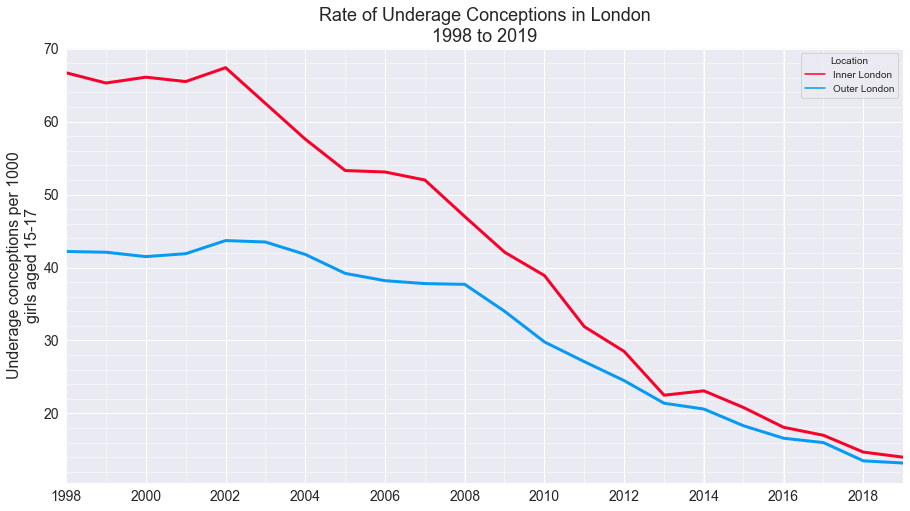

In [14]:
ax = sns.lineplot(data=ucl, x='Year', y='Rate per 1000', hue='Location', palette=twocat_palette, linewidth = 3)
ax.set(title='Rate of Underage Conceptions in London\n1998 to 2019')
ax.set_ylabel('Underage conceptions per 1000\ngirls aged 15-17')
ax.set_xlabel(None)
plt.gcf().set_size_inches(15, 8)

# Change grid and frequency of xticks to make graph easier to read and interpret
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
ax.set_xlim(pd.to_datetime('1998-01-01'), pd.to_datetime('2019-01-01'))
plt.xticks([str(y) for y in pd.date_range('1998', periods = 11, freq ='2Y').year.tolist()])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

We can see teenage pregnancy rates have fallen significantly over the last two decades, with rates in inner London in 2019 at about a fifth of what they were at their peak in 2002. 

We may be interested in questions which require us to look at specific boroughs, such as: which borough had the historically highest rates? We can see all the data at once using a heatmap. The use of colour allows us to process a large amount of numerical data intuatively starting with using the second stage of visual information processing (pattern perception). Additionally, it makes the third stage of visual information processing (querying the plot) quicker, with colours being much easier to locate than values. 

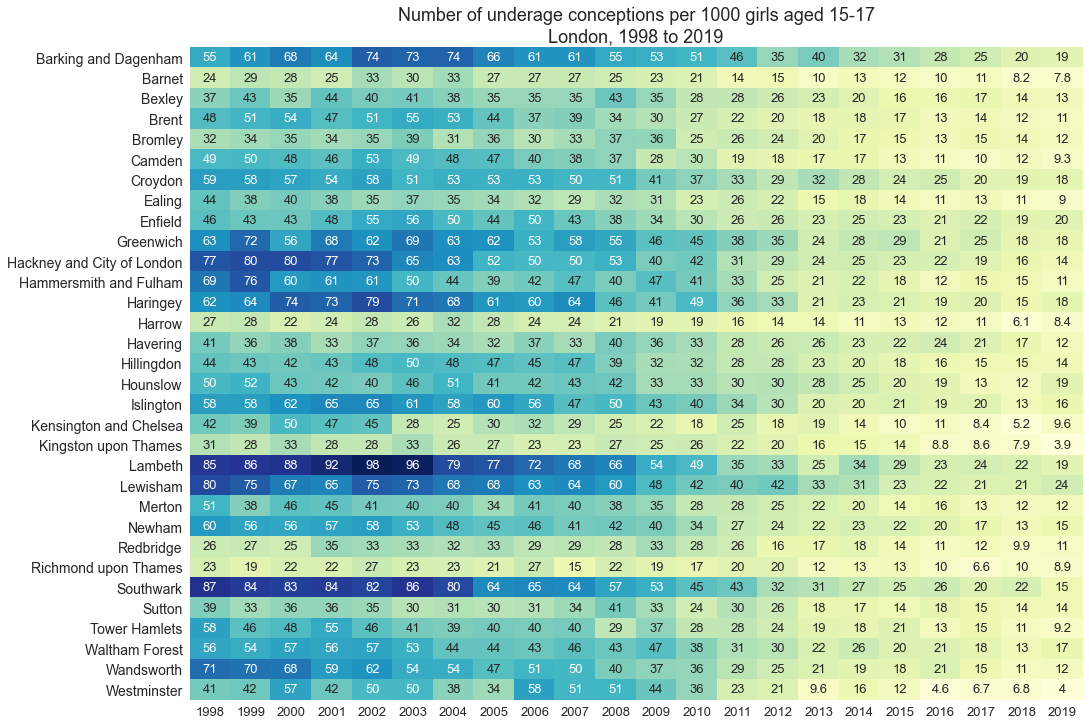

In [15]:
plt.figure(figsize=(16,12))

ucb_piv = ucb.reset_index().pivot('Borough', 'Year', 'Rate per 1000')

ax = sns.heatmap(ucb_piv, cmap='YlGnBu', annot=True, annot_kws={'fontsize':13}, cbar=False, xticklabels=1)

ax.set_title('Number of underage conceptions per 1000 girls aged 15-17\nLondon, 1998 to 2019')
ax.set_xlabel(None)
ax.set_ylabel(None)

# Format x-axis
ax.set_xticklabels([y.strftime('%Y') for y in ucb_piv.columns.tolist()], rotation=0, size=13)

plt.show()

While the heatmap gives us a good sense of range for boroughs where peak rates were very high, it is more difficult to get a sense of range for other boroughs. We can plot range using a lollipop plot, which allows to easily see magnitude of teenage pregnancy decrease per borough:

In [16]:
# Calculate min and max rate of underage conception for each borough
ucbmin = ucb[['Rate per 1000']].groupby(level=[1]).min()
ucbmax = ucb[['Rate per 1000']].groupby(level=[1]).max()

# Join into one dataframe and calculate difference
ucbminmax = ucbmin.join(ucbmax, lsuffix=' min', rsuffix=' max')
ucbminmax.rename(columns={'Rate per 1000 max':'Maximum', 'Rate per 1000 min':'Minimum'}, inplace=True)
ucbminmax['Difference'] = ucbminmax['Maximum'] - ucbminmax['Minimum']

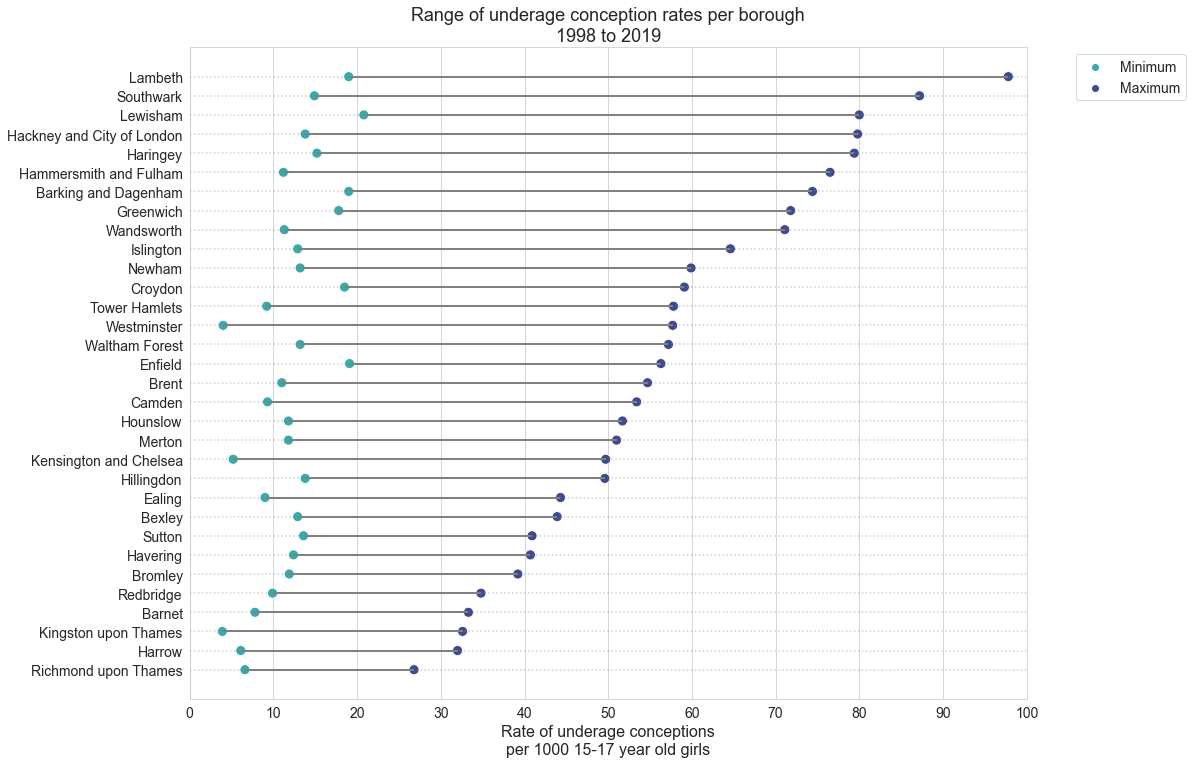

In [17]:
sns.set_style('whitegrid')
plt.gcf().set_size_inches(15, 12)

# Sort dataframe so that plot is sorted by highest maximimum rate of teenage pregnancies
ucbminmax.sort_values(by='Maximum', ascending=False, inplace=True)

# Plot range lines
ax=plt.hlines(y=ucbminmax.index, xmin=ucbminmax['Minimum'], xmax=ucbminmax['Maximum'], color='grey', lw=2)

# Plot light dotted lines to allow the user to easily link each line witht the borough
ax=plt.hlines(y=ucbminmax.index, xmin=0, xmax=100, color='grey', linestyles='dotted', alpha=0.4)

# Melt dataframe so we can plot both sets of scatters on it at once using seaborn
ucbminmax_melt = pd.melt(ucbminmax, value_vars=['Minimum', 'Maximum'], var_name='MinMax', ignore_index=False)

ax = sns.scatterplot(data=ucbminmax_melt, x='value', y='Borough', hue='MinMax', s=100, palette='mako_r')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='14')

# Format plot so that we have 10 neat grid lines
ax.set_xlim(0,100)
plt.xticks(range(0, 101, 10))
ax.grid(axis='y')

ax.set_title('Range of underage conception rates per borough\n1998 to 2019')
ax.set_xlabel('Rate of underage conceptions\nper 1000 15-17 year old girls')
ax.set_ylabel(None)
plt.show()

Light grey dotted line to allow the viewer to easily link the borough to it's range. The graph is sorted by highest maximum rate, which is much more differentiated than minimum rate.

### Choropleths

As the data is both spatial and time-series, an intuative way of letting the viewer get a sense of how rates have changed over time, while giving information about location, is to create an animated choropleth. I followed [this tutorial](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d) [10] to create a basic map of London with colourmap, then adding other elements: animation/map update, inner London boundary, interactive buttons.

In [18]:
# Import borough shape files
london_map = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
london_map.set_index('NAME', inplace=True)

# Import shape file for only inner and outer London, to be able to show the inner London boundary
london_map_io = gpd.read_file('lp-falp-2006-inner-outer-london-shp/lp-falp-2006-inner-outer-london.shp')
inner_london = london_map_io[london_map_io['Designated']=='Inner']

To plot our data on a map, Hackney and City of London need to be separated back out. I created a function to do this:

In [19]:
def mappingDF(df):
    mdf = df.copy()
    
    mdf.reset_index(inplace=True)
    
    mdf['Borough'] = mdf['Borough'].astype('object')
    
    # Copy Hackney and City of London rows and rename to City of London
    col = mdf[mdf['Borough']=='Hackney and City of London']
    col.loc[:, 'Borough']  = 'City of London'
    
    # Append back to dataframe
    mdf = mdf.append(col, ignore_index=True)
    
    # Rename Hackney and City of London to just Hackney 
    mdf.loc[mdf['Borough']=='Hackney and City of London', 'Borough']  = 'Hackney'
    
    mdf.set_index('Borough', inplace=True)
    
    mdf = london_map.join(mdf)
    
    return mdf

We can see we now have all the London map information appended with underage conception information:

In [20]:
ucb_map = mappingDF(ucb)

ucb_map.head()

GSS_CODE  HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
Barking and Dagenham  E09000002  3779.934      169.15         F     None   
Barking and Dagenham  E09000002  3779.934      169.15         F     None   
Barking and Dagenham  E09000002  3779.934      169.15         F     None   
Barking and Dagenham  E09000002  3779.934      169.15         F     None   
Barking and Dagenham  E09000002  3779.934      169.15         F     None   

                     SUB_2006  \
Barking and Dagenham     None   
Barking and Dagenham     None   
Barking and Dagenham     None   
Barking and Dagenham     None   
Barking and Dagenham     None   

                                                               geometry  \
Barking and Dagenham  MULTIPOLYGON (((543905.400 183199.100, 543905....   
Barking and Dagenham  MULTIPOLYGON (((543905.400 183199.100, 543905....   
Barking and Dagenham  MULTIPOLYGON (((543905.400 183199.100, 543905....   
Barking and Dagenham  MULTIPOLYGON (((543905.400 183199.100, 543905....   
Barking and Dagenham  MULTIPOLYGON (((543905.400 183199.100, 543905....   

                          Location       Year  Number  Rate per 1000  \
Barking and Dagenham  Outer London 1998-01-01     156           54.6   
Barking and Dagenham  Outer London 1999-01-01     180           61.2   
Barking and Dagenham  Outer London 2000-01-01     216           67.5   
Barking and Dagenham  Outer London 2001-01-01     215           63.6   
Barking and Dagenham  Outer London 2002-01-01     236           74.4   

                      Population  
Barking and Dagenham        2857  
Barking and Dagenham        2941  
Barking and Dagenham        3200  
Barking and Dagenham        3381  
Barking and Dagenham        3172

We need to run interactive plots in notebook rather than inline. After interactive cells, we have to run %matplotlib inline  so the rest of the graphs in the notebook display correctly. This reloads the plot below into an inline image, which removes it's animation and interactivity. If the image is being displayed as inline (or not displayed at all), please rerun the code cell to view the plot correctly. Alternatively, please see the GIF of the interactive plot which follows.

<IPython.core.display.Javascript object>


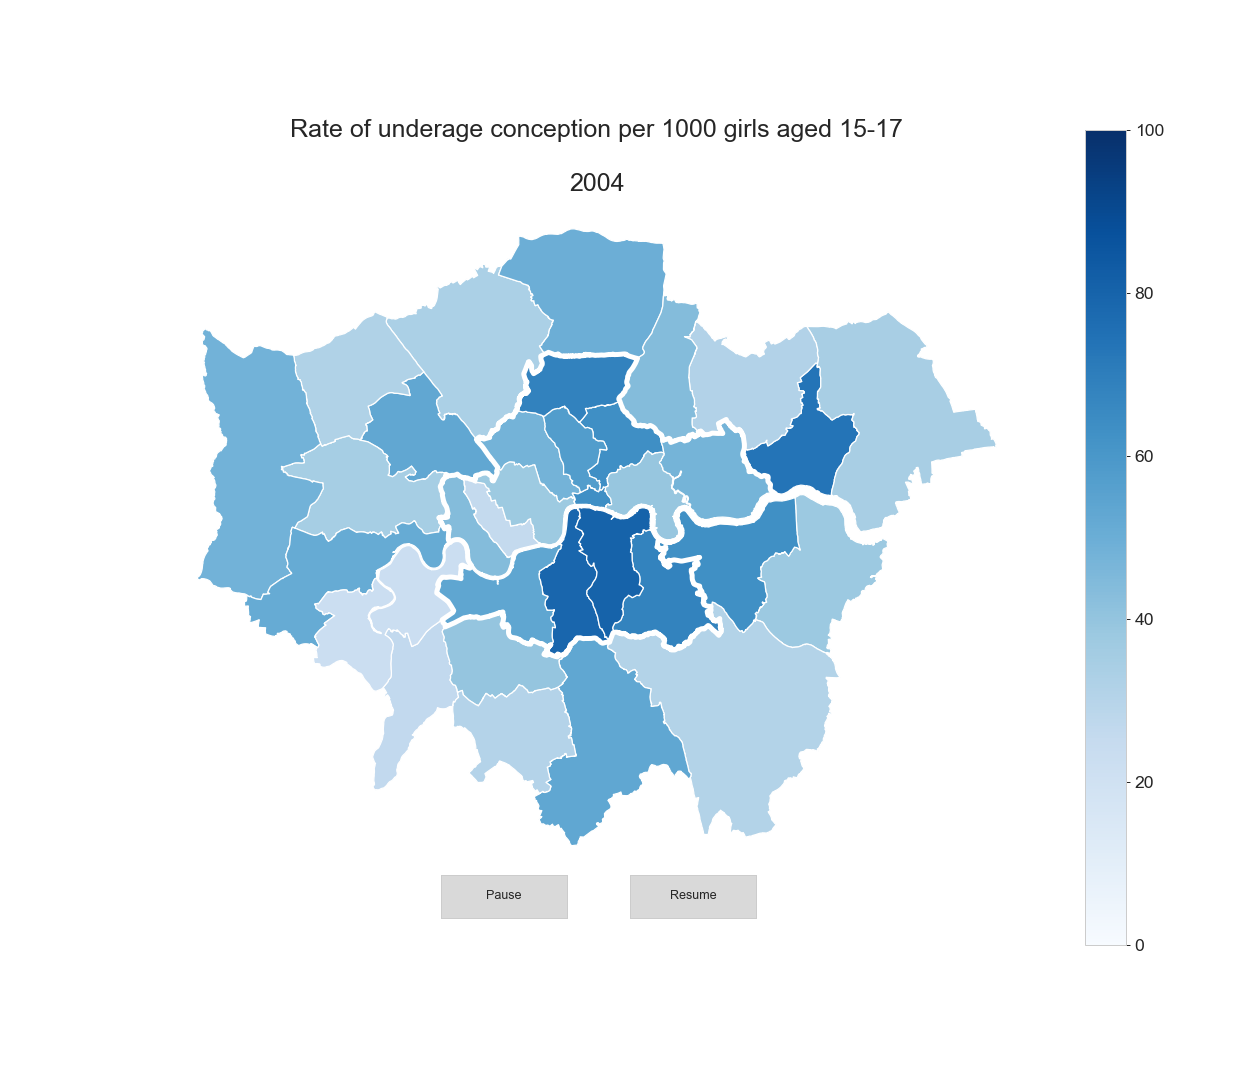

In [44]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(14, 12))

# Plot map starting with rates as they were in 1998
ucb_map[ucb_map['Year']==pd.to_datetime('1998')].plot(column='Rate per 1000', 
                                                             cmap='Blues', ax=ax, vmin=0, vmax=100)

# Plot the inner London boundary as a thick line
inner_london.plot(facecolor='none', edgecolor='white', lw=4, ax=ax)
ax.set_title('Rate of underage conception per 1000 girls aged 15-17\n\n1998', size=20)

# Add colourbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.05)    

ax.axis('off')

# Pause and resume buttons
ax_pause = plt.axes([0.35, 0.15, 0.1, 0.04])
ax_resume = plt.axes([0.50, 0.15, 0.1, 0.04])

pause = Button(ax_pause, 'Pause')
resume = Button(ax_resume, 'Resume')

def pauseAnimation(event):
    animator.event_source.stop()
    
def resumeAnimation(event):
    animator.event_source.start()
    
pause.on_clicked(pauseAnimation)
resume.on_clicked(resumeAnimation)
    
# Function to update the map
def animateMap(year):
    ucb_map[ucb_map['Year']==pd.to_datetime(str(year))].plot(column='Rate per 1000', 
                                                             cmap='Blues', ax=ax, vmin=0, vmax=100)
    inner_london.plot(facecolor='none', edgecolor='white', lw=4, ax=ax)
    ax.set_title(('Rate of underage conception per 1000 girls aged 15-17\n\n' + str(year)), size=20)

# Creating a looping animation
animator = FuncAnimation(fig, animateMap, frames = range(1998, 2020), interval = 1200, repeat=True)
plt.show()

GIF version of the above interactive plot:
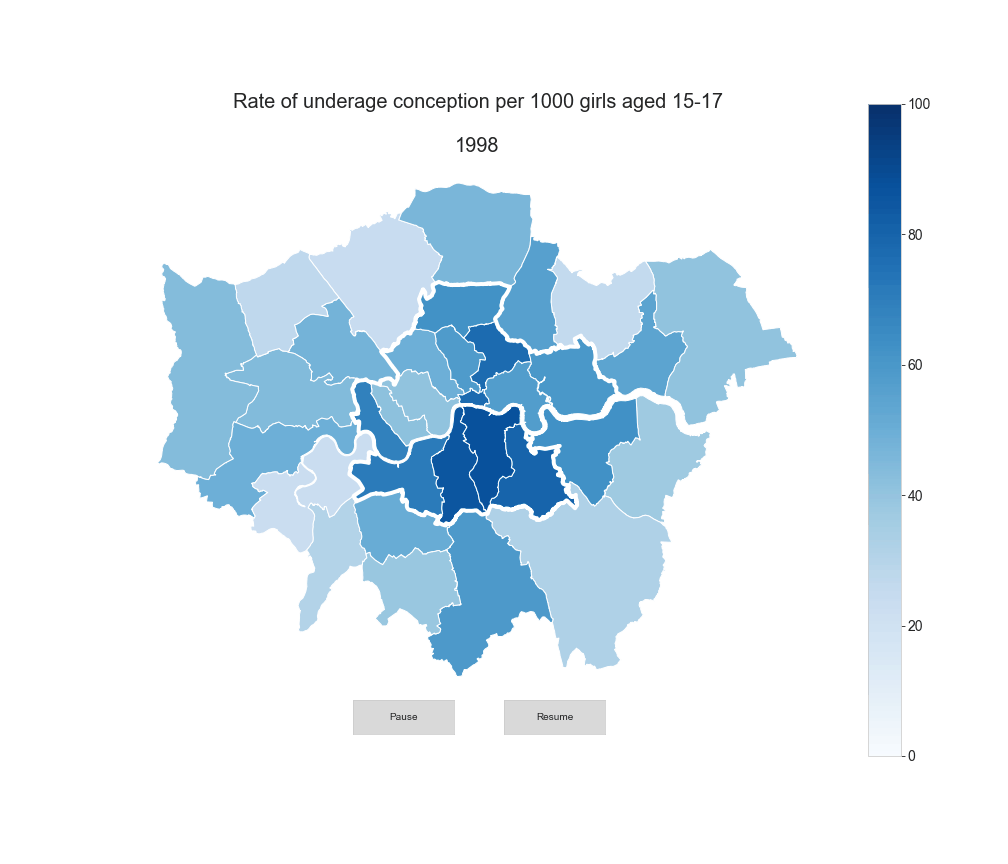

I think this plot gives viewers a great sense of how substantially underage conception rates have dropped, and that the highest rates were traditionally in inner London. I left borough names off as the animation moves too quickly for them to be read, and they create visual distraction in an animation. I have created a second interactive plot with year slider and buttons (for ease of scrolling through years), with full labels to allow for in depth exploration of the data.

<IPython.core.display.Javascript object>


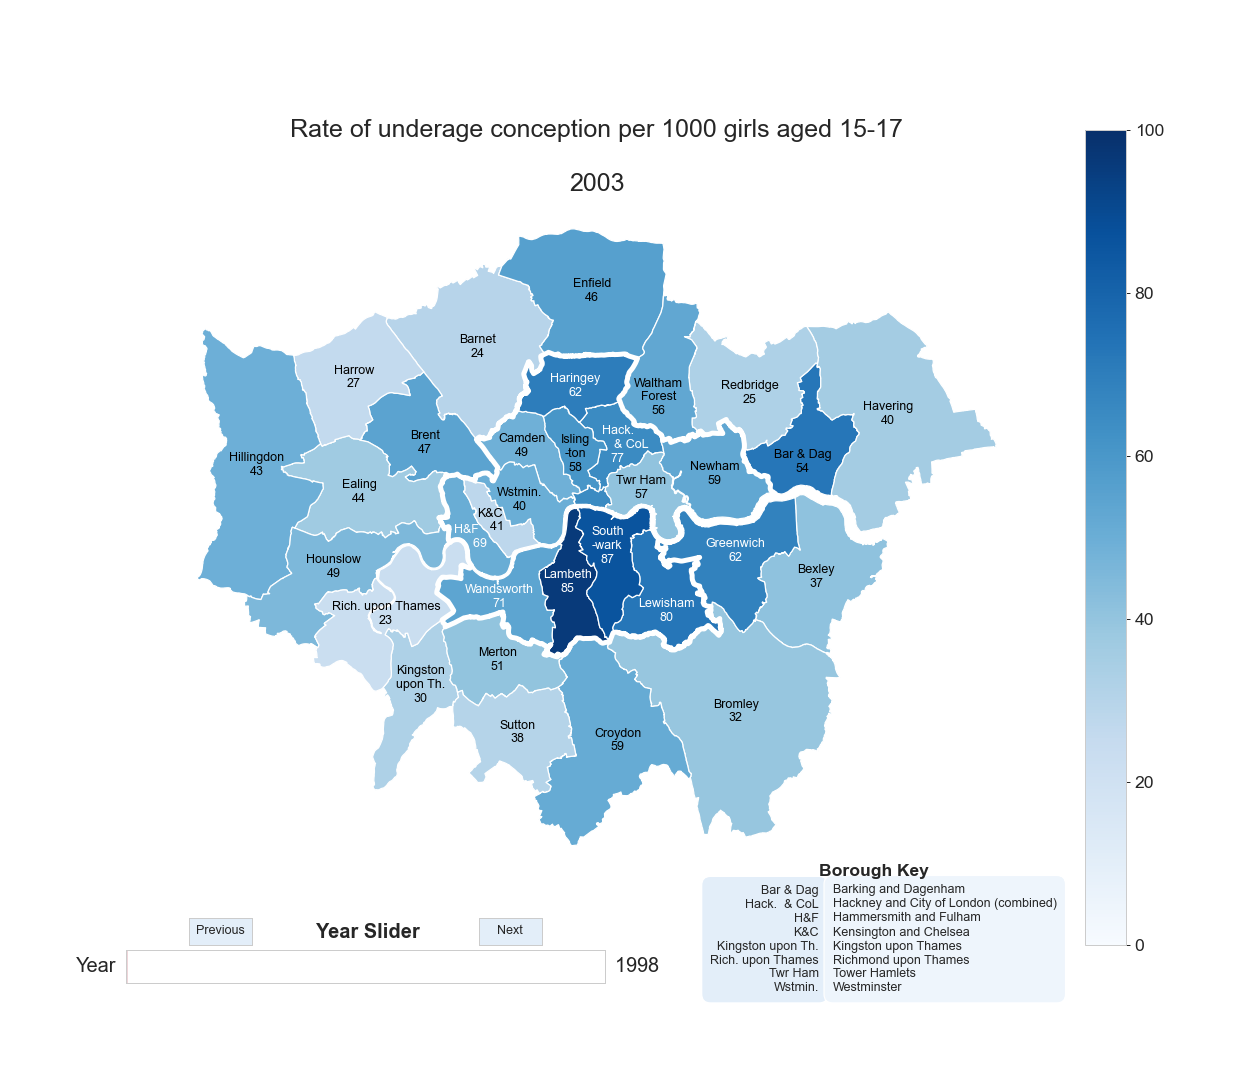

In [45]:
# Please RUN CODE AGAIN if plot is not interactive or not visisble. 
# (Alternatively, please see the GIF of the interactive plot which follows)

%matplotlib notebook
fig, ax = plt.subplots(figsize=(14, 12))

ucb_map_yr = ucb_map[ucb_map['Year']==pd.to_datetime('1998')]

ucb_map_yr.plot(column='Rate per 1000', cmap='Blues', ax=ax, vmin=0, vmax=100)
inner_london.plot(facecolor='none', edgecolor='white', lw=4, ax=ax)

ax.set_title('Rate of underage conception per 1000 girls aged 15-17\n\n1998', size=20)

# Add colourbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.05)    

# Plot borough name and underage conception rate

# Some boroughs need to be abbreviated on the map
borough_abrv = {'Barking and Dagenham':'Bar & Dag', 'Hackney':'Hack.\n        & CoL',
                'Hammersmith and Fulham':'H&F', 'Kensington and Chelsea':'K&C', 
                'Kingston upon Thames':'Kingston\nupon Th.', 'Richmond upon Thames':'Rich. upon Thames',
               'Tower Hamlets':'Twr Ham', 'Waltham Forest':'Waltham\nForest', 'Westminster':'Wstmin.',
               'Southwark':'South\n-wark', 'Islington':'Isling\n-ton'}

for bor in ucb_map_yr.index.tolist():
    # Get coordinates for centre of borough's polygon
    b_coords = ucb_map_yr['geometry'][bor].centroid.coords[0]
    xcoord = b_coords[0]
    ycoord = b_coords[1]
    
    # Get label
    if bor in borough_abrv.keys():
        label = borough_abrv[bor]
    else:
        label = bor
        
    if bor == 'Hammersmith and Fulham':
        label += '\n        ' + str(int(ucb_map_yr['Rate per 1000'][bor]))
    elif bor == 'Kensington and Chelsea':
        label += '\n    ' + str(int(ucb_map_yr['Rate per 1000'][bor]))
    elif bor == 'City of London':
        label = None
    else:
        label += '\n' + str(int(ucb_map_yr['Rate per 1000'][bor]))
    
    # Get what the text colour should be
    if ucb_map_yr['Rate per 1000'][bor] > 60:
        col = 'white'
    else:
        col = 'black'
    
    # Some labels need to be jiggled a little to make them sit pleasingly within their borough polygon
    x_jiggle = {'Lewisham':200, 'Croydon':1000, 'Kensington and Chelsea':-600, 'Ealing':-500, 'Westminster':-550,
                'Waltham Forest':-500, 'Kingston upon Thames':600, 'Lambeth':-200, 'Southwark':-300,
               'Hammersmith and Fulham':-350, 'Wandsworth':-500, 'Camden':-600, 'Tower Hamlets':-400,
               'Barking and Dagenham':-250, 'Islington':100, 'Hackney':-100}
    y_jiggle = {'Lewisham':-1000, 'Hounslow':600, 'Westminster':70, 'Waltham Forest':-1600, 'Greenwich':500,
                'Kingston upon Thames':800, 'Lambeth':750, 'Southwark':1100, 'Hammersmith and Fulham':-550,
               'Camden':400, 'Tower Hamlets':350, 'Redbridge':-500, 'Haringey':-200, 'Barking and Dagenham':-1200,
               'Brent':-550, 'Islington':-500, 'Hackney':-350}
    
    if bor in x_jiggle.keys():
        xcoord += x_jiggle[bor]
    
    if bor in y_jiggle.keys():
        ycoord += y_jiggle[bor]
    
    # Plot the text
    ax.text(xcoord, ycoord, label, color=col, va='center', ha='center')

# Now we need to make a key for abbreviated borough names
ba = pd.DataFrame.from_dict(borough_abrv, orient ='index')
ba.drop(['Southwark', 'Islington', 'Waltham Forest'], inplace=True)
ba.rename(index={'Hackney':'Hackney and City of London (combined)'}, inplace=True)

# Clean up new line characters and spaces in the abbreviations
abbrvs = [re.sub('        ', ' ', re.sub('\\n', ' ', ab)) for ab in ba[0]]

# Create lists of abbreviations and labels
ab_lst = '\n'.join(abbrvs)

bor_lst = '\n'.join(ba.index.tolist())

box1 = {'boxstyle': 'round', 'edgecolor': None, 'facecolor':plt.get_cmap('Blues')(0.1), 'pad':0.7}
box2 = {'boxstyle': 'round', 'edgecolor': None, 'facecolor':plt.get_cmap('Blues')(0.05), 'pad':0.7}

# Right bottom key
ax.text(549000, 145000, ab_lst, va='bottom', ha='right', bbox=box1)
ax.text(550000, 145000, bor_lst, va='bottom', ha='left', bbox=box2)
ax.text(553000, 154000, 'Borough Key', va='center', ha='center', fontsize=14, fontweight='demibold')
    
ax.axis('off')

# Add slider
ax_year = plt.axes([0.10, 0.09, 0.38, 0.03])
yr_slider = Slider(ax=ax_year, label='Year', valmin=1998, valmax=2019, valstep=1, color=plt.get_cmap('Blues')(0.5))
yr_slider.label.set_size(16)
#yr_slider.label.set_weight('bold')
yr_slider.valtext.set_fontsize(16)

ax.text(516000, 149500, 'Year Slider', va='center', ha='center', fontsize=16, fontweight='demibold')

# Buttons to move between years
ax_prev = plt.axes([0.15, 0.125, 0.05, 0.025])
ax_next = plt.axes([0.38, 0.125, 0.05, 0.025])

prevyr = Button(ax_prev, 'Previous', color=plt.get_cmap('Blues')(0.1), hovercolor=plt.get_cmap('Blues')(0.3))
nextyr = Button(ax_next, 'Next', color=plt.get_cmap('Blues')(0.1), hovercolor=plt.get_cmap('Blues')(0.3))

def prevYr(event):
    if yr_slider.val == 1998:
        yr_slider.set_val(2019)
    else:
        yr_slider.set_val(yr_slider.val-1)
    
def nextYr(event):
    if yr_slider.val == 2019:
        yr_slider.set_val(1998)
    else:
        yr_slider.set_val(yr_slider.val+1)
    
prevyr.on_clicked(prevYr)
nextyr.on_clicked(nextYr)

def updateMap(year):
    
    ucb_map_yr = ucb_map[ucb_map['Year']==pd.to_datetime(str(year))]
    
    ucb_map_yr.plot(column='Rate per 1000', cmap='Blues', ax=ax, vmin=0, vmax=100)
    inner_london.plot(facecolor='none', edgecolor='white', lw=4, ax=ax)
    ax.set_title(('Rate of underage conception per 1000 girls aged 15-17\n\n' + str(year)), size=20)
    
    # Remove all existing text so text isn't stacked on text (resulting in text looking granulated and thick)
    for txt in ax.texts:
        txt.set_visible(False)
    
    # Replot borough labels to ensure they contrast borough colour
    for bor in ucb_map_yr.index.tolist():
        # Get coordinates for centre of borough's polygon
        b_coords = ucb_map_yr['geometry'][bor].centroid.coords[0]

        # Get label
        if bor in borough_abrv.keys():
            label = borough_abrv[bor]
        else:
            label = bor
            
        if bor == 'Hammersmith and Fulham':
            label += '\n        ' + str(int(ucb_map_yr['Rate per 1000'][bor]))
        elif bor == 'Kensington and Chelsea':
            label += '\n    ' + str(int(ucb_map_yr['Rate per 1000'][bor]))
        elif bor == 'City of London':
            label = None
        else:
            label += '\n' + str(int(ucb_map_yr['Rate per 1000'][bor]))

        if ucb_map_yr['Rate per 1000'][bor] > 60:
            col = 'white'
        else:
            col = 'black'

        xcoord = b_coords[0]
        ycoord = b_coords[1]

        if bor in x_jiggle.keys():
            xcoord += x_jiggle[bor]

        if bor in y_jiggle.keys():
            ycoord += y_jiggle[bor]

        ax.text(xcoord, ycoord, label, color=col, va='center', ha='center')

    # Replot borough key and slider title as gets removed with all the labels
    # Right bottom key
    ax.text(549000, 145000, ab_lst, va='bottom', ha='right', bbox=box1)
    ax.text(550000, 145000, bor_lst, va='bottom', ha='left', bbox=box2)
    ax.text(553000, 154000, 'Borough Key', va='center', ha='center', fontsize=14, fontweight='bold')
    
    ax.text(516000, 149500, 'Year Slider', va='center', ha='center', fontsize=16, fontweight='demibold')


# Call update function when slider value is changed
yr_slider.on_changed(updateMap)    

plt.show()

GIF version of the above interactive plot:
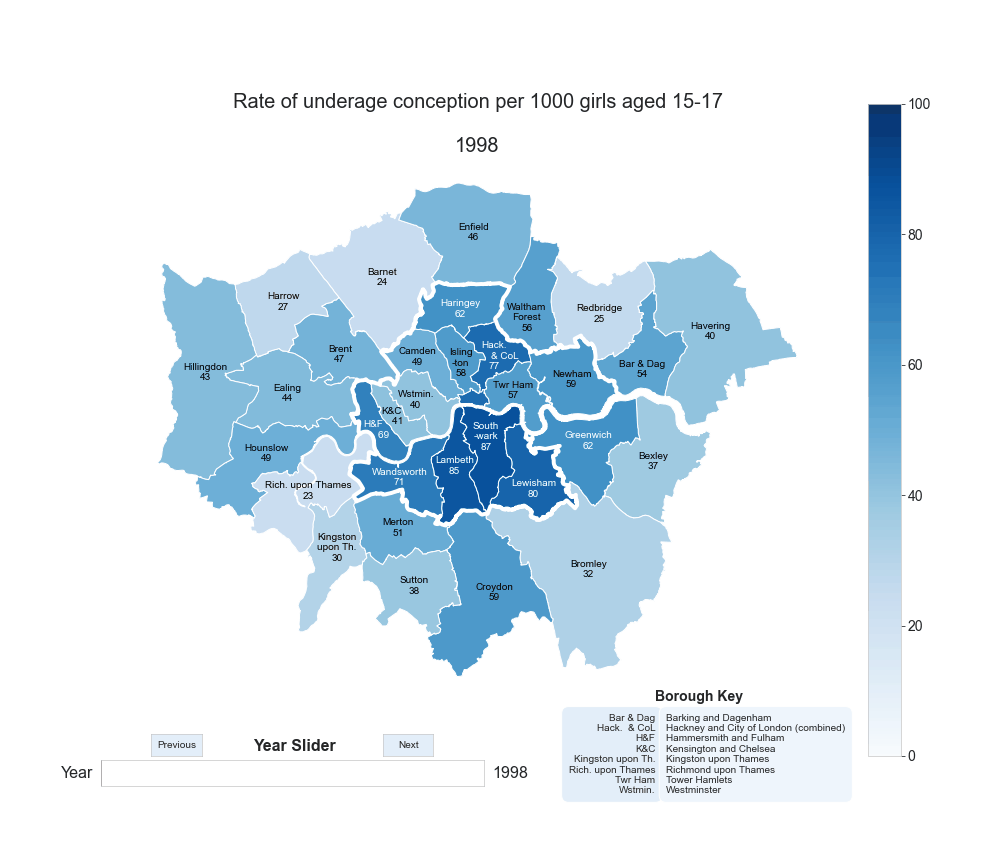

In [23]:
%matplotlib inline

Finally, to give the viewer a sense of which boroughs have seen the greatest reduction in underage pregnancies and where they are located, I plot the difference between minimum and maximum rates per borough on a map:

In [24]:
# Get version of dataframe with map geometry for plotting
ucbminmax_map = mappingDF(ucbminmax)

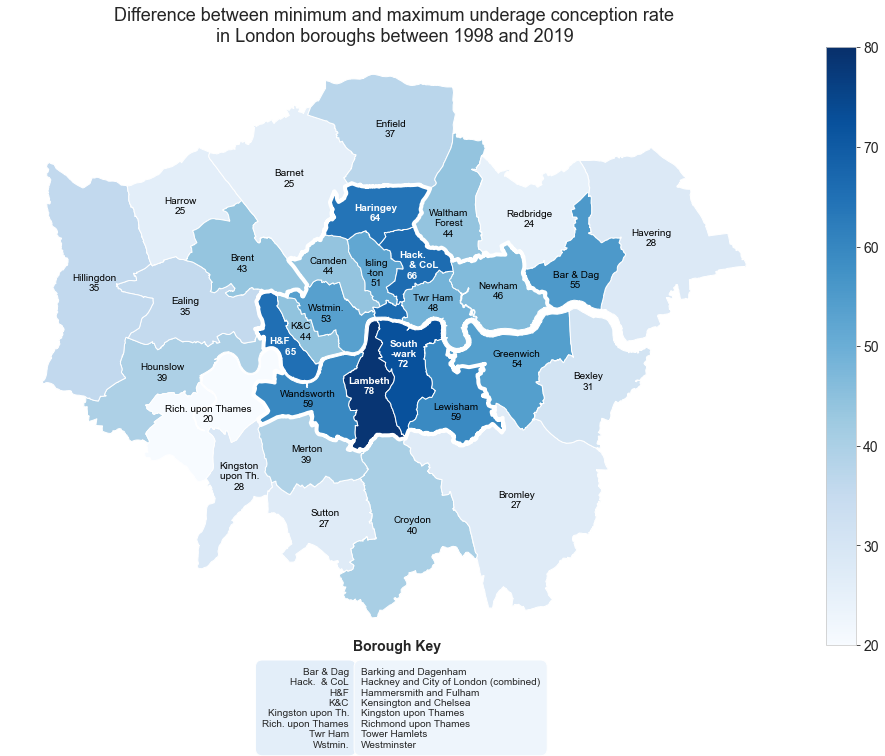

In [25]:
fig, ax = plt.subplots(ncols=1, figsize=(16, 11))

ucbminmax_map.plot(column='Difference', cmap='Blues', ax=ax, vmin=20, vmax=80)
inner_london.plot(facecolor='none', edgecolor='white', lw=4, ax=ax)

ax.set_title('Difference between minimum and maximum underage conception rate\nin London boroughs between 1998 and 2019')

# Add colourbar'
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=20, vmax=80))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.05)

# Plot borough names and difference values on map

for bor in ucbminmax_map.index.tolist():
    # Get coordinates for centre of borough's polygon
    b_coords = ucbminmax_map['geometry'][bor].centroid.coords[0]
    
    # Get label
    if bor in borough_abrv.keys():
        label = borough_abrv[bor]
    else:
        label = bor
        
    if bor == 'Hammersmith and Fulham':
        label += '\n        ' + str(int(ucbminmax_map['Difference'][bor]))
    elif bor == 'Kensington and Chelsea':
        label += '\n    ' + str(int(ucbminmax_map['Difference'][bor]))
    elif bor == 'City of London':
        label = None
    else:
        label += '\n' + str(int(ucbminmax_map['Difference'][bor]))
    
    if ucbminmax_map['Difference'][bor] > 60:
        # A slight boldness to white text makes it easier to read
        col = 'white'
        fw = 'demibold'
    else:
        col = 'black'
        fw = 'normal'
    
    xcoord = b_coords[0]
    ycoord = b_coords[1]
    
    if bor in x_jiggle.keys():
        xcoord += x_jiggle[bor]
    
    if bor in y_jiggle.keys():
        ycoord += y_jiggle[bor]
    
    ax.text(xcoord, ycoord, label, color=col, va='center', ha='center', fontweight=fw)

# Now we need to make a key for abbreviated borough names
# Centre bottom key
ax.text(533000, 153500, 'Borough Key', va='center', ha='center', fontsize=14, fontweight='bold')
ax.text(529000, 145000, ab_lst, va='bottom', ha='right', bbox=box1)
ax.text(530000, 145000, bor_lst, va='bottom', ha='left', bbox=box2)

ax.axis('off')
plt.show()

Although I have added text to indicate the exact difference value for each borough, I have left the colourmap legend because it gives viewers an immediate understanding that dark/deep blue corresponds to a higher difference value, and individual values only need to be looked at in detail if they are of interest.

## Child poverty

### How has child poverty changed?

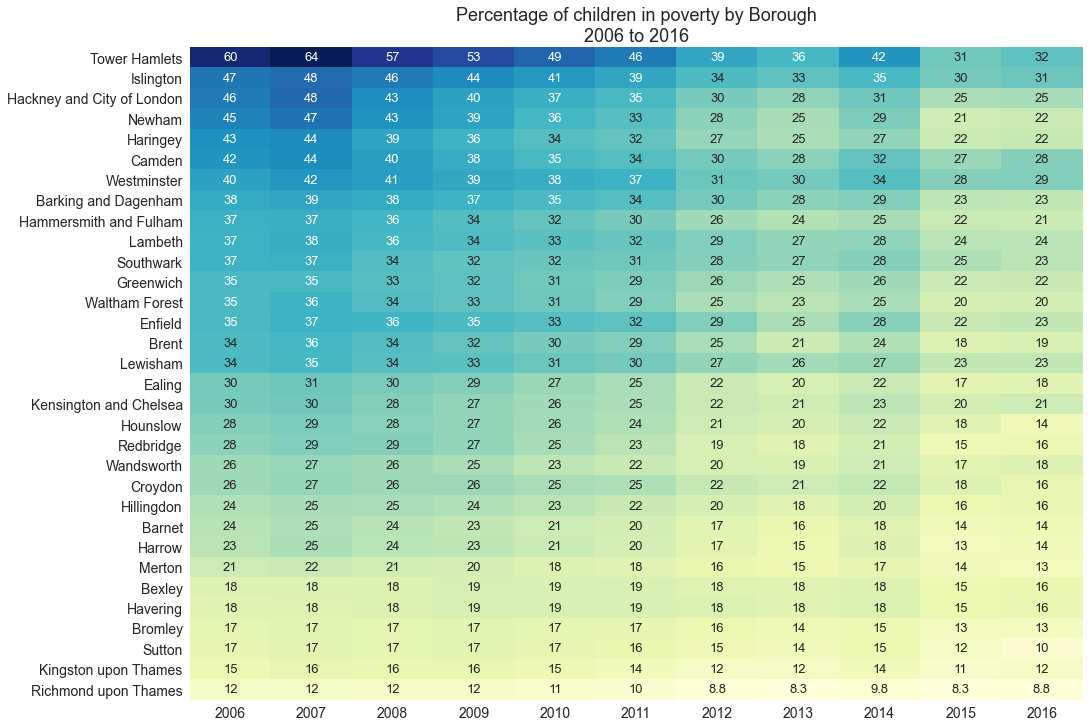

In [26]:
plt.figure(figsize=(16,12))

cp_piv = cp.reset_index().pivot('Borough', 'Year', '% of Children in Poverty')

ax = sns.heatmap(cp_piv.sort_values('2006-01-01', ascending=False), cmap='YlGnBu', 
                 annot=True, annot_kws={'fontsize':13}, cbar=False, xticklabels=1)

ax.set_title('Percentage of children in poverty by Borough\n2006 to 2016')
ax.set_xlabel(None)
ax.set_ylabel(None)

# Format x-axis
ax.set_xticklabels([y.strftime('%Y') for y in cp_piv.columns.tolist()], rotation=0)

plt.show()

We can see that as a whole, child poverty rates have declined. I did not format the annotations as percentages as it made the plot look busier and made the numbers less readable.

### How is child poverty correlated with underage conception?

In [27]:
# Combine underage conception and child poverty datasets - only need years for which we have child poverty data
cp_ucb = ucb.join(cp, how='right')

cp_ucb_grp = cp_ucb.groupby(['Year', 'Location']).mean().unstack(1)

cp_ucb_grp.rename(columns = {'Rate per 1000': 'Underage conception rate'}, inplace=True)

# Get only data we need and reformat index to display year
cp_ucb_grp = cp_ucb_grp.loc[:, ['Underage conception rate', '% of Children in Poverty']]
cp_ucb_grp.index = cp_ucb_grp.index.strftime('%Y')

cp_ucb_grp.style.background_gradient(cmap='YlOrRd', axis=None).set_precision(1)

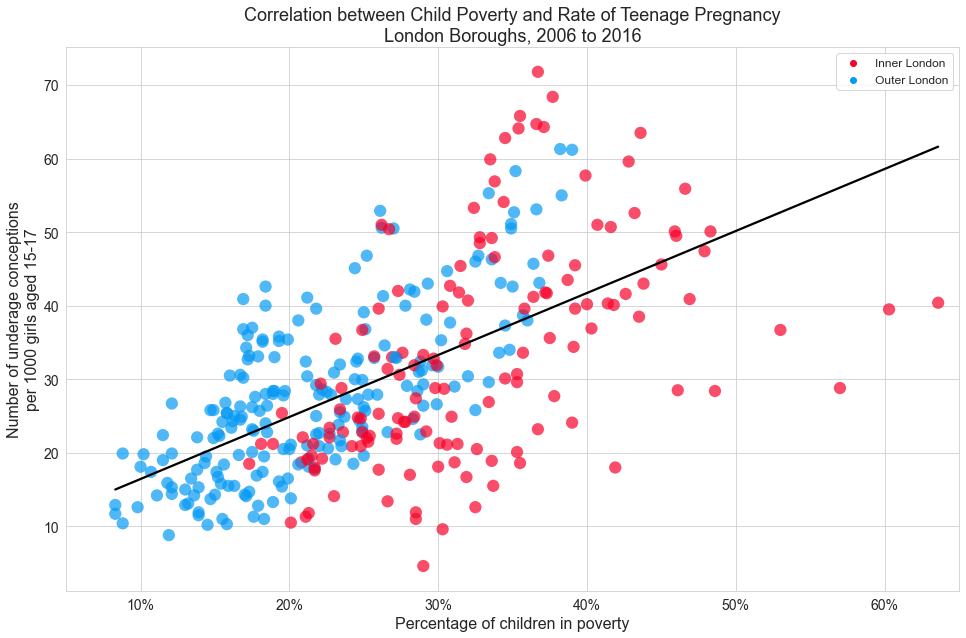

In [28]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(data=cp_ucb, x='% of Children in Poverty', y='Rate per 1000', hue='Location', 
                palette=twocat_palette, s=150, linewidth=0, alpha = 0.7)
sns.regplot(data=cp_ucb, x='% of Children in Poverty', y='Rate per 1000', scatter=False, ci=False, ax=ax,
           color='black')
ax.set_xlim(5, 65)
ax.set_ylabel('Number of underage conceptions\nper 1000 girls aged 15-17')
ax.set_title('Correlation between Child Poverty and Rate of Teenage Pregnancy\nLondon Boroughs, 2006 to 2016')
ax.set_xlabel('Percentage of children in poverty')
plt.xticks(np.linspace(10, 60, 6), [str(int(x))+'%' for x in np.linspace(10, 60, 6)])
ax.legend(fontsize='large')
plt.show()

We can see we have some datapoints which are outliers in regards to having a high proportion of child poverty but relatively low teenage pregnancy rates. Let's investigate which boroughs these datapoints belong to:

In [29]:
cp_ucb.loc[(cp_ucb['% of Children in Poverty'] > 40) & (cp_ucb['Rate per 1000'] < 45)]

Number  Rate per 1000  Population  \
Location     Borough       Year                                            
Inner London Camden        2006-01-01     103           40.1        2569   
                           2007-01-01     104           38.5        2701   
                           2008-01-01     107           36.9        2900   
             Islington     2009-01-01     117           43.0        2721   
                           2010-01-01     105           40.3        2605   
             Newham        2007-01-01     219           40.9        5355   
                           2008-01-01     226           41.6        5433   
             Tower Hamlets 2006-01-01     158           39.5        4000   
                           2007-01-01     156           40.4        3861   
                           2008-01-01     109           28.8        3785   
                           2009-01-01     132           36.7        3597   
                           2010-01-01     101           28.4        3556   
                           2011-01-01     104           28.5        3649   
                           2014-01-01      74           18.0        4111   

                                       % of Children in Poverty  \
Location     Borough       Year                                   
Inner London Camden        2006-01-01                      41.8   
                           2007-01-01                      43.5   
                           2008-01-01                      40.3   
             Islington     2009-01-01                      43.8   
                           2010-01-01                      41.4   
             Newham        2007-01-01                      46.9   
                           2008-01-01                      42.6   
             Tower Hamlets 2006-01-01                      60.3   
                           2007-01-01                      63.6   
                           2008-01-01                      57.0   
                           2009-01-01                      53.0   
                           2010-01-01                      48.6   
                           2011-01-01                      46.1   
                           2014-01-01                      41.9   

                                       Population under 20  
Location     Borough       Year                             
Inner London Camden        2006-01-01              43432.0  
                           2007-01-01              43711.0  
                           2008-01-01              43442.0  
             Islington     2009-01-01              40423.0  
                           2010-01-01              41028.0  
             Newham        2007-01-01              79713.0  
                           2008-01-01              81889.0  
             Tower Hamlets 2006-01-01              59232.0  
                           2007-01-01              59306.0  
                           2008-01-01              59269.0  
                           2009-01-01              60291.0  
                           2010-01-01              61578.0  
                           2011-01-01              61950.0  
                           2014-01-01              69292.0

We can see many of these datapoints belong to Tower Hamlets. Let's replot the scatterplot, highlighting Tower Hamlets:

In [30]:
# Create highlighting palette to highlight Tower Hamlets
highlight_pal = {b:'lightblue' for b in cp_ucb.index.get_level_values(1).unique()}
highlight_pal['Tower Hamlets'] = 'teal'

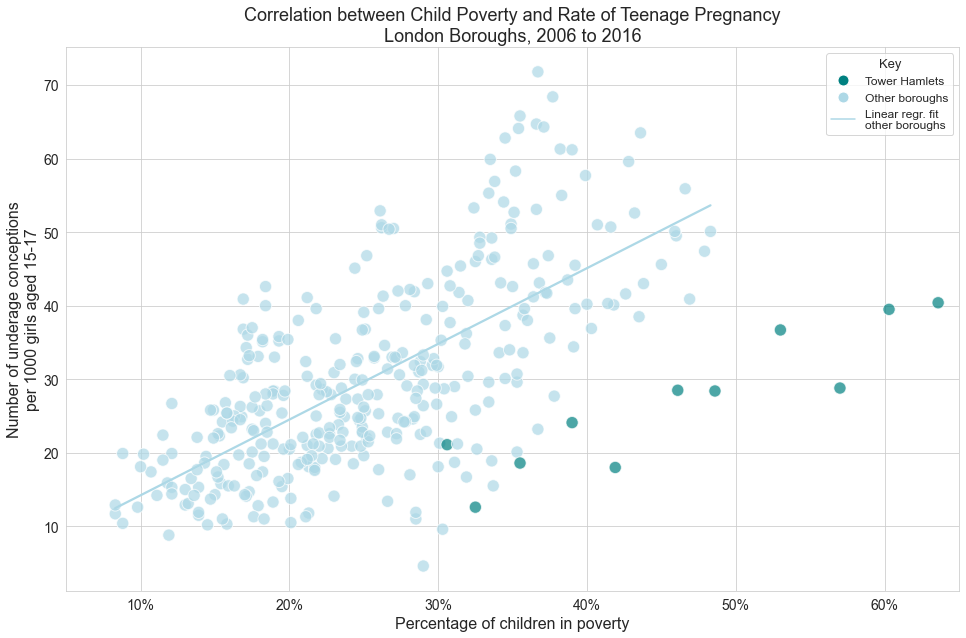

In [31]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))

ax = sns.scatterplot(data=cp_ucb, x='% of Children in Poverty', y='Rate per 1000', hue='Borough', 
                palette=highlight_pal, s=150, linewidth=1, alpha = 0.7)

# Create dataframe excluding Tower Hamlets to plot line of best fit over all other boroughs
cp_ucb_eth = cp_ucb[cp_ucb.index.get_level_values(1) != 'Tower Hamlets']

sns.regplot(data=cp_ucb_eth, x='% of Children in Poverty', y='Rate per 1000', scatter=False, ci=False, ax=ax, 
            color='lightblue')

ax.set_xlim(5, 65)
ax.set_ylabel('Number of underage conceptions\nper 1000 girls aged 15-17')
ax.set_title('Correlation between Child Poverty and Rate of Teenage Pregnancy\nLondon Boroughs, 2006 to 2016')
ax.set_xlabel('Percentage of children in poverty')
plt.xticks(np.linspace(10, 60, 6), [str(int(x))+'%' for x in np.linspace(10, 60, 6)])

# Create new custom legend
new_leg = [Line2D([0], [0], marker='o', color='white', label='Tower Hamlets', markerfacecolor='teal', markersize=11),
           Line2D([0], [0], marker='o', color='white', label='Other boroughs', markerfacecolor='lightblue',
                  markersize=11),
          Line2D([0], [0], color='lightblue', label='Linear regr. fit\nother boroughs')]
ax.legend(handles=new_leg, fontsize='large', title='Key', title_fontsize=13)

plt.show()

This plot highlights that Tower Hamlets appears to be an outlier, retaining relatively low teenage pregnancy rates despite significant poverty. This would make an interesting case study, to see which administrative policies may explain how young people in poverty were shielded.

We can see that in all other boroughs, the relationship between poverty and teenage pregnancy is strong: the linear regression line indicates that, on average, a 1% reduction in child poverty in a borough corresponds to 1 less underage conception per 1000 15-17 year old girls every year.

## GCSE achievement

### Eligibility for free school meals (FSM)

For some graphs it is useful to be able wrap labels into several lines. I created a function to do this:

In [32]:
def wrapLabel(lab, max_line_len=20):
    if len(lab) > (max_line_len + 1):
        words = lab.split(' ')
        lines = []
        current_line = ''
        
        for word in words:
            if (len(current_line) + len(word)) < max_line_len:
                current_line += ' ' + word
            else:
                lines.append(current_line.strip())
                current_line = word
        lines.append(current_line.strip())
        
        return '\n'.join(lines)
    else:
        return lab

#### FSM eligibility between GCSE systems

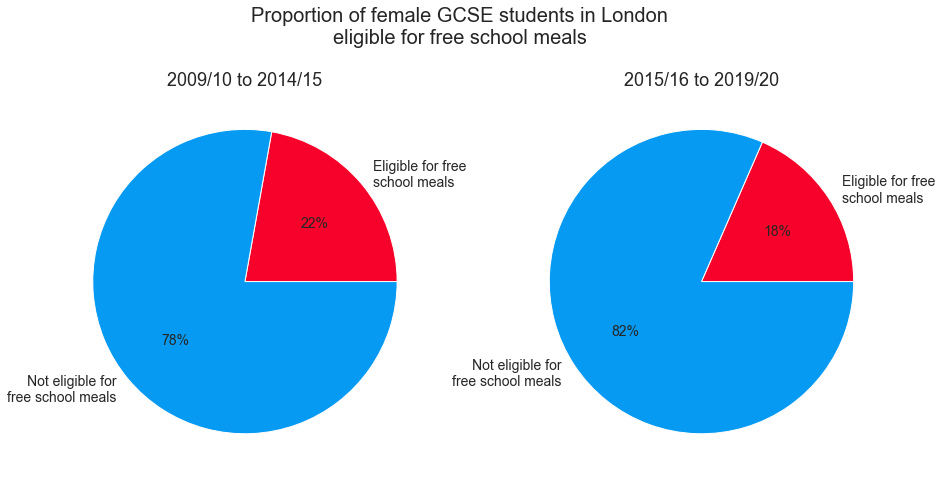

In [33]:
plt.gcf().set_size_inches(15, 8)
plt.suptitle('Proportion of female GCSE students in London\neligible for free school meals', size=20)

plt.subplot(1, 2, 1)
go_fsm_eligibility = [gcse_old['Number of eligible pupils','Eligible for free school meals'].sum(), gcse_old['Number of eligible pupils','Not eligible for free school meals'].sum()]
labels = ['Eligible for free\nschool meals', 'Not eligible for\nfree school meals']
plt.pie(go_fsm_eligibility, labels=labels, colors=twocat_palette, autopct='%.0f%%', textprops={'fontsize': 14})
plt.title('2009/10 to 2014/15')

plt.subplot(1, 2, 2)
gn_fsm_eligibility = [gcse_new['Number of eligible pupils','Eligible for free school meals'].sum(), gcse_new['Number of eligible pupils','Not eligible for free school meals'].sum()]
plt.pie(gn_fsm_eligibility, labels=labels, colors=twocat_palette, autopct='%.0f%%', textprops={'fontsize': 14})
plt.title('2015/16 to 2019/20')

plt.show()

#### FSM eligibility between inner and outer London by year

In [34]:
fsm_elig_old = gcse_old.loc[:, ('Number of eligible pupils',
                                ['Eligible for free school meals', 'Not eligible for free school meals'])]

fsm_elig_old.columns = fsm_elig_old.columns.droplevel(0)

fsm_elig_new = gcse_new.loc[:, ('Number of eligible pupils', 
                                ['Eligible for free school meals', 'Not eligible for free school meals'])]

fsm_elig_new.columns = fsm_elig_new.columns.droplevel(0)

# Combine dataframes from old and new GCSE system into one 
fsm_elig = fsm_elig_old.append(fsm_elig_new)

# Group by Year
fsm_elig_gy = fsm_elig.groupby(['Location', 'Year']).sum()

# Calculate proportion
for i in fsm_elig_gy.index:
    total_pupils = fsm_elig_gy['Eligible for free school meals'][i] + fsm_elig_gy['Not eligible for free school meals'][i]
    fsm_elig_gy.loc[i, 'Eligible for free school meals'] = fsm_elig_gy['Eligible for free school meals'][i] / total_pupils
    fsm_elig_gy.loc[i, 'Not eligible for free school meals'] = fsm_elig_gy['Not eligible for free school meals'][i] / total_pupils

fsm_elig_gy.unstack(0).loc[:, ('Eligible for free school meals', slice(None))].style.format('{:.0%}')

#### FSM eligibility between borough

In [35]:
fsm_elig_bor = fsm_elig.groupby('Borough').sum().reset_index()

for i in fsm_elig_bor.index:
    total_pupils = fsm_elig_bor['Eligible for free school meals'][i] + fsm_elig_bor['Not eligible for free school meals'][i]
    fsm_elig_bor.loc[i, 'Eligible for free school meals'] = fsm_elig_bor['Eligible for free school meals'][i] *100/ total_pupils
    fsm_elig_bor.loc[i, 'Not eligible for free school meals'] = fsm_elig_bor['Not eligible for free school meals'][i]*100/ total_pupils

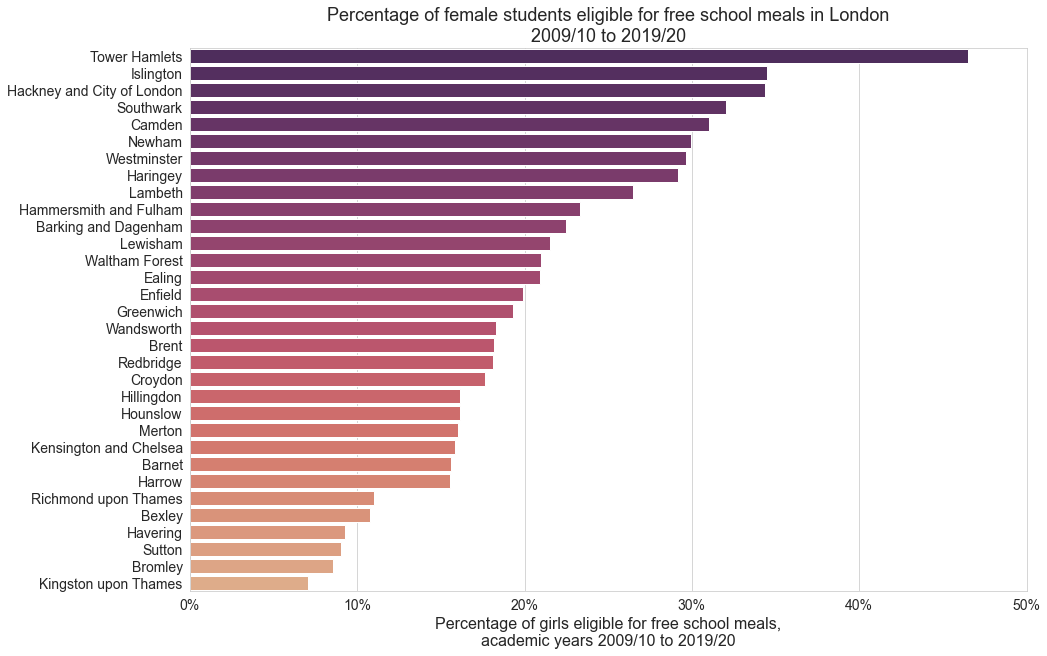

In [36]:
sns.set_style('whitegrid')
plt.gcf().set_size_inches(15, 10)
ax = sns.barplot(data=fsm_elig_bor, x='Eligible for free school meals', y='Borough', orient='h', palette='flare_r',
                order=fsm_elig_bor.sort_values('Eligible for free school meals', ascending=False)['Borough'].tolist())
ax.set_ylabel(None)
ax.set_xlabel('Percentage of girls eligible for free school meals,\nacademic years 2009/10 to 2019/20')
ax.set_xlim(0,50)
plt.xticks(np.linspace(0, 50, 6), [str(int(x))+'%' for x in np.linspace(0, 50, 6)])
ax.set_title('Percentage of female students eligible for free school meals in London\n2009/10 to 2019/20')
plt.show()

A barchart with many bars which are all the same colour can be affronting to the eyes as a solid block of colour, so here I have chosen a perceputally uniform colour palette (with restricted luminance variation so it does not blend into the white background) to allow for the automatic interpretation of lighter colour = smaller value. We can see the boroughs which had the highest rates of child poverty, like Tower Hamlets, also have the highest rates of FSM eligibility.

### Relationship between % of students eligible for free school meals and teenage pregnancies

To combine the free school meal eligibility and underage conception rates dataframes, we will need to transform the year variable for the FSM dataframe, as it is currently the ordinal academic year. We will use 'graduation year' to allow merging with underage conceptions instead.

In [37]:
# Create new version of the fsm_elig dataframe with graduation year in the index
fsm_elig_gyi = fsm_elig.rename(index={y:pd.to_datetime(y[:4], format='%Y') for y in fsm_elig.index.get_level_values(2).unique()})

# Combine underage conception and FSM eligibility datasets - only need years for which we have both
fsm_ucb = ucb.join(fsm_elig_gyi, how='right').rename(columns={'Number':'Number of underage conceptions',
                                                             'Rate per 1000':'Rate of underage conceptions per 1000',
                                                             'Population':'Population of 15-17 year old girls'})

# Recalculate number of students eligible/not eligible for free school meals to percentage
for i in fsm_ucb.index:
    total_pupils = fsm_ucb['Eligible for free school meals'][i] + fsm_ucb['Not eligible for free school meals'][i]
    fsm_ucb.loc[i, 'Eligible for free school meals'] = fsm_ucb['Eligible for free school meals'][i] *100/ total_pupils
    fsm_ucb.loc[i, 'Not eligible for free school meals'] = fsm_ucb['Not eligible for free school meals'][i]*100/ total_pupils

fsm_ucb.sort_index(0, inplace=True)

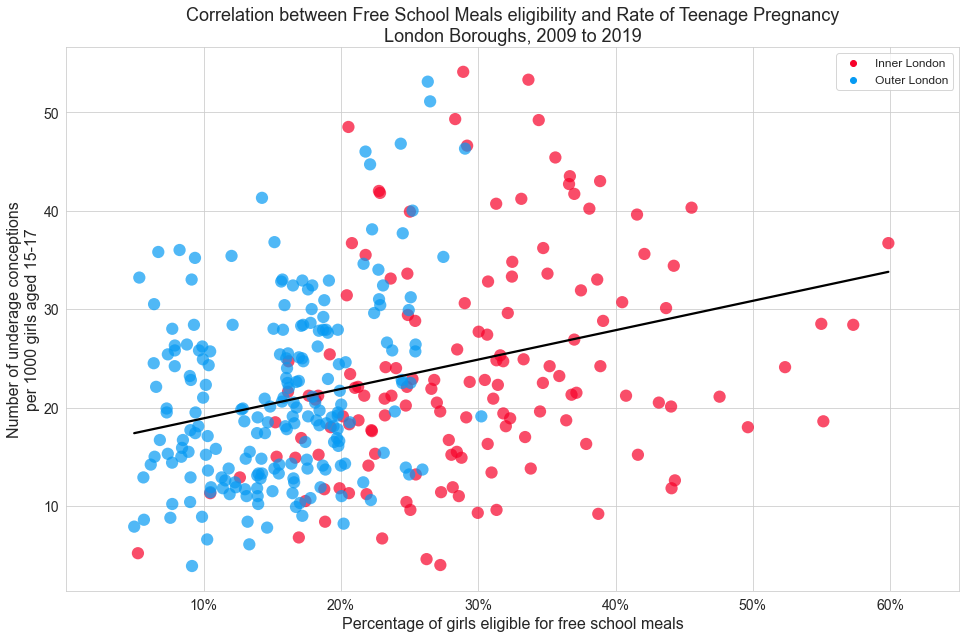

In [38]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(data=fsm_ucb, x='Eligible for free school meals', y='Rate of underage conceptions per 1000', 
                     hue='Location', palette=twocat_palette, s=150, linewidth=0, alpha = 0.7)
sns.regplot(data=fsm_ucb, x='Eligible for free school meals', y='Rate of underage conceptions per 1000', 
            scatter=False, ci=False, ax=ax, color='black')
ax.set_xlim(0, 65)
ax.set_ylabel('Number of underage conceptions\nper 1000 girls aged 15-17')
ax.set_title('Correlation between Free School Meals eligibility and Rate of Teenage Pregnancy\nLondon Boroughs, 2009 to 2019')
ax.set_xlabel('Percentage of girls eligible for free school meals')
plt.xticks(np.linspace(10, 60, 6), [str(int(x))+'%' for x in np.linspace(10, 60, 6)])
ax.legend(fontsize='large')
plt.show()

We can see although FSM eligibility is correlated with rate of teenage pregnancies, this relationship is much weaker than the relationship between teenage pregancies and HMRC-defined child poverty. On average, a reduction in FSM eligibility of 50% only correlates to a reduction of approximatelty 15 underage conceptions a year per 1000 relevant population. This could potentially be because a proportion of students go to school in a borough different to the one they live in. Additonally, many students who are not technically in poverty may qualify for free school meals - for example, children whose parents are temporarily out of work and on Job Seeker's Allowance.

### Exploring GCSE achievement based on eligibility for free school meals

In [39]:
# Need to melt the dataframes to allow for plotting of histograms

# GSCE achievement - old system
go_ach = gcse_old.loc[:, ('Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades', 
                          ['Eligible for free school meals', 'Not eligible for free school meals'])]

go_ach.columns = go_ach.columns.droplevel(0)

go_ach = pd.melt(go_ach, value_vars=['Eligible for free school meals', 'Not eligible for free school meals'],
                 var_name='School meal eligibility', 
                 value_name='Percentage of pupils achieving 5+ A*-C grades', ignore_index=False)

# Rename so labels are clearer in charts
go_ach.loc[go_ach['School meal eligibility']=='Eligible for free school meals', 'School meal eligibility'] = 'Students eligible for free school meals'
go_ach.loc[go_ach['School meal eligibility']=='Not eligible for free school meals', 'School meal eligibility'] = 'Students not eligible for free school meals'

# GSCE achievement - new system
gn_ach = gcse_new.loc[:, ('Average Attainment 8 score per pupil', 
                          ['Eligible for free school meals', 'Not eligible for free school meals'])]

gn_ach.columns = gn_ach.columns.droplevel(0)

gn_ach = pd.melt(gn_ach, value_vars=['Eligible for free school meals', 'Not eligible for free school meals'],
                 var_name='School meal eligibility', 
                 value_name='Average Attainment 8 score per pupil', ignore_index=False)

# Rename so labels are clearer in charts
gn_ach.loc[gn_ach['School meal eligibility']=='Eligible for free school meals', 'School meal eligibility'] = 'Students eligible for free school meals'
gn_ach.loc[gn_ach['School meal eligibility']=='Not eligible for free school meals', 'School meal eligibility'] = 'Students not eligible for free school meals'

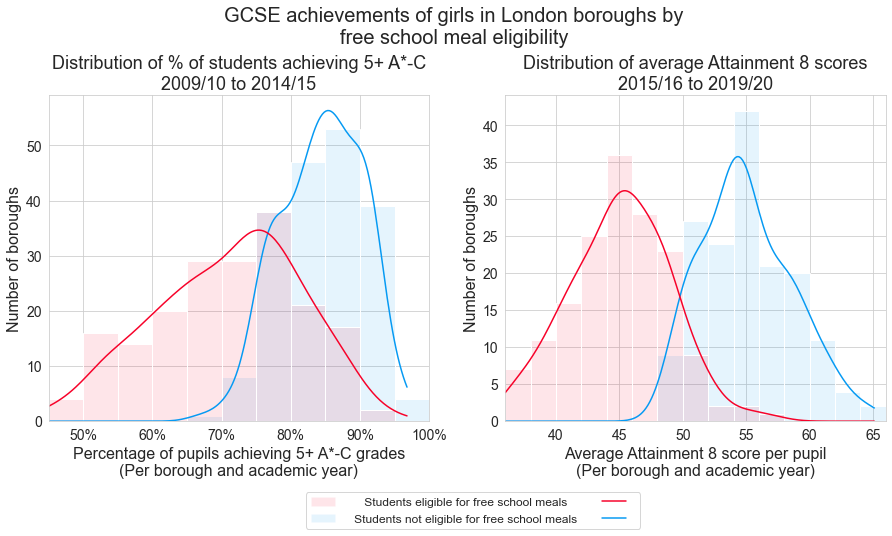

In [40]:
plt.gcf().set_size_inches(15, 6)
plt.suptitle('GCSE achievements of girls in London boroughs by\nfree school meal eligibility', size=20, y=0.99,
            va='bottom')

plt.subplot(1, 2, 1)
ax = sns.histplot(hue='School meal eligibility', x='Percentage of pupils achieving 5+ A*-C grades', data=go_ach,
                palette=twocat_palette, kde=True, alpha=0.1, binwidth=5, legend=False)
ax.set_xlim(45, 100)
ax.set_xticklabels([str(int(x))+'%' for x in ax.get_xticks()])
ax.set_ylabel('Number of boroughs')
ax.set_xlabel('Percentage of pupils achieving 5+ A*-C grades\n(Per borough and academic year)')
ax.set_title('Distribution of % of students achieving 5+ A*-C\n2009/10 to 2014/15')

plt.subplot(1, 2, 2)
ax = sns.histplot(hue='School meal eligibility', x='Average Attainment 8 score per pupil', data=gn_ach,
                palette=twocat_palette, kde=True, alpha=0.1, binwidth=2, legend=False)
ax.set_ylabel('Number of boroughs')
ax.set_xlabel('Average Attainment 8 score per pupil\n(Per borough and academic year)')
ax.set_xlim(36, 66)
ax.set_title('Distribution of average Attainment 8 scores\n2015/16 to 2019/20')

# Create new legend
new_leg = [Patch(facecolor='xkcd:cherry red', edgecolor='w', alpha=0.1, label='      Students eligible for free school meals'),
          Patch(facecolor='xkcd:azure', edgecolor='w', alpha=0.1, label='   Students not eligible for free school meals'),
          Line2D([0], [0], color='xkcd:cherry red', label=None),
           Line2D([0], [0], color='xkcd:azure', label=None)]

ax.legend(handles=new_leg, fontsize='large', title_fontsize=13, bbox_to_anchor=(0.37, -0.2), ncol=2,
         facecolor='white')

plt.show()

### GCSE achievement over time

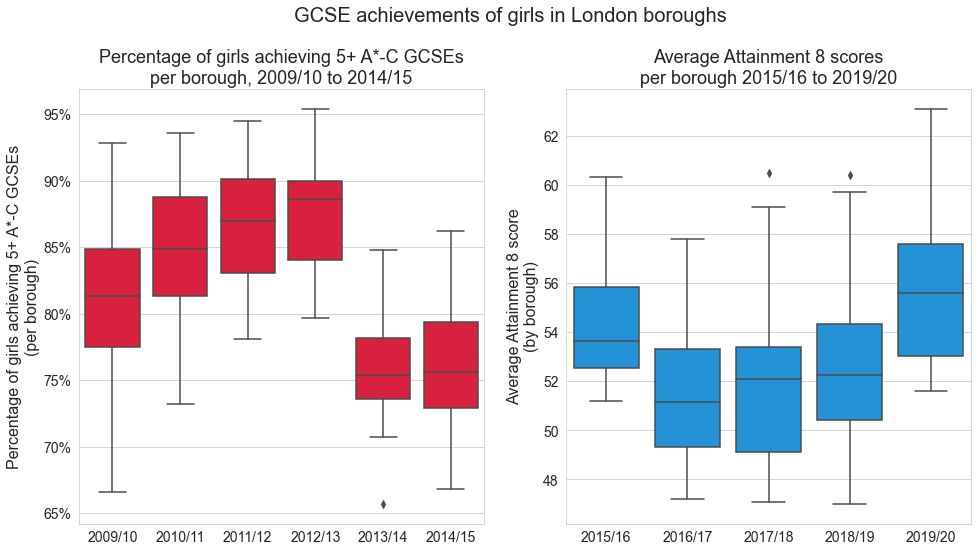

In [41]:
plt.gcf().set_size_inches(16, 8)
plt.suptitle('GCSE achievements of girls in London boroughs', size=20, y=0.99,
            va='bottom')

plt.subplot(1, 2, 1)
ax = sns.boxplot(data=gcse_old.reset_index(), x='Year', color='xkcd:cherry red', 
                 y=('Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades', 'All Pupils'))
ax.set_xlabel(None)
ax.set_ylabel('Percentage of girls achieving 5+ A*-C GCSEs\n(per borough)')
ax.set_yticklabels([str(int(y))+'%' for y in ax.get_yticks()])
ax.set_title('Percentage of girls achieving 5+ A*-C GCSEs\nper borough, 2009/10 to 2014/15')

plt.subplot(1, 2, 2)
ax = sns.boxplot(data=gcse_new.reset_index(), x='Year', color='xkcd:azure',
                 y=('Average Attainment 8 score per pupil', 'All Pupils'))
ax.set_xlabel(None)
ax.set_ylabel('Average Attainment 8 score\n(by borough)')
ax.set_title('Average Attainment 8 scores\nper borough 2015/16 to 2019/20')

plt.show()

We can see the number of girls achieving 5+ A\*-C GCSEs was steadily rising until 2013/14, when we saw a dramatic drop (I double checked these figures and they are correct - this was a pattern nationally), likely due to a substantial reworking of the GCSE system at the time. Since 2016/17, we see that GCSE grades have once again been rising.

### Exploring the relationship between GCSE achievement and teenage pregnancies

In [42]:
# Create new versions of the dataframes with graduation year in the index
gcse_old_gyi = gcse_old.rename(index={y:pd.to_datetime(y[:4], format='%Y') for y in gcse_old.index.get_level_values(2).unique()})
gcse_new_gyi = gcse_new.rename(index={y:pd.to_datetime(y[:4], format='%Y') for y in gcse_new.index.get_level_values(2).unique()})

# Make new version of underage conceptions dataframe with multiindex columns so will merge cleanly with GCSE dfs
ucbmi = ucb.copy()
ucbmi.columns = pd.MultiIndex.from_product([['Underage conceptions'], ucbmi.columns])

# Combine underage conception and gcse datasets - only need years for which we have both
gcse_old_ucb = ucbmi.join(gcse_old_gyi, how='right')
gcse_new_ucb = ucbmi.join(gcse_new_gyi, how='right')

gcse_old_ucb.sort_index(0, inplace=True)
gcse_new_ucb.sort_index(0, inplace=True)

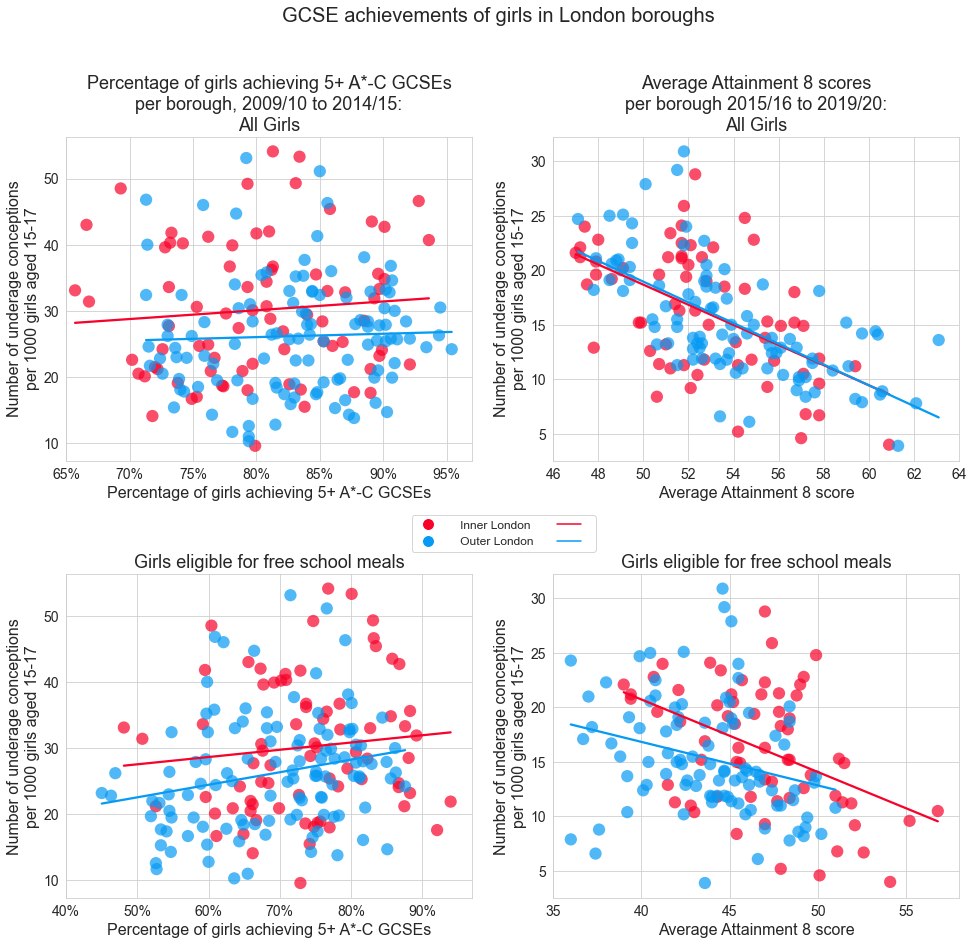

In [43]:
plt.gcf().set_size_inches(16, 14)
plt.subplots_adjust(hspace=0.35)
plt.suptitle('GCSE achievements of girls in London boroughs', size=20, y=0.99,
            va='bottom')

plt.subplot(2, 2, 1)
ax = sns.scatterplot(data=gcse_old_ucb, 
                     x=('Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades', 'All Pupils'),
                     y=('Underage conceptions', 'Rate per 1000'), legend=False,
                     hue='Location', palette=twocat_palette, s=150, linewidth=0, alpha = 0.7)

# Seaborn regplot throws an error if we try to define multiindices as x and y - interprets them as tuples
# Merge column multiindicies
gcse_old_ucb_mc = gcse_old_ucb.copy()
gcse_old_ucb_mc.columns = gcse_old_ucb.columns.map('_'.join)

gcse_new_ucb_mc = gcse_new_ucb.copy()
gcse_new_ucb_mc.columns = gcse_new_ucb.columns.map('_'.join)

sns.regplot(data=gcse_old_ucb_mc[gcse_old_ucb_mc.index.get_level_values(0)=='Inner London'], 
            x='Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades_All Pupils',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:cherry red')
sns.regplot(data=gcse_old_ucb_mc[gcse_old_ucb_mc.index.get_level_values(0)=='Outer London'], 
            x='Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades_All Pupils',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:azure')
ax.set_xlim(65, 97)
ax.set_xticklabels([str(int(x))+'%' for x in ax.get_xticks()])
ax.set_ylabel('Number of underage conceptions\nper 1000 girls aged 15-17')
ax.set_xlabel('Percentage of girls achieving 5+ A*-C GCSEs')
ax.set_title('Percentage of girls achieving 5+ A*-C GCSEs\nper borough, 2009/10 to 2014/15:\nAll Girls')

plt.subplot(2, 2, 2)
ax = sns.scatterplot(data=gcse_new_ucb, x=('Average Attainment 8 score per pupil', 'All Pupils'),
                     y=('Underage conceptions', 'Rate per 1000'), legend=False,
                     hue='Location', palette=twocat_palette, s=150, linewidth=0, alpha = 0.7)
sns.regplot(data=gcse_new_ucb_mc[gcse_new_ucb_mc.index.get_level_values(0)=='Inner London'], 
            x='Average Attainment 8 score per pupil_All Pupils',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:cherry red')
sns.regplot(data=gcse_new_ucb_mc[gcse_new_ucb_mc.index.get_level_values(0)=='Outer London'], 
            x='Average Attainment 8 score per pupil_All Pupils',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:azure')
ax.set_xlim(46, 64)
ax.set_ylabel('Number of underage conceptions\nper 1000 girls aged 15-17')
ax.set_xlabel('Average Attainment 8 score')
ax.set_title('Average Attainment 8 scores\nper borough 2015/16 to 2019/20:\nAll Girls')

plt.subplot(2, 2, 3)
ax = sns.scatterplot(data=gcse_old_ucb, 
                     x=('Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades', 'Eligible for free school meals'),
                     y=('Underage conceptions', 'Rate per 1000'), legend=False,
                     hue='Location', palette=twocat_palette, s=150, linewidth=0, alpha = 0.7)
sns.regplot(data=gcse_old_ucb_mc[gcse_old_ucb_mc.index.get_level_values(0)=='Inner London'], 
            x='Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades_Eligible for free school meals',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:cherry red')
sns.regplot(data=gcse_old_ucb_mc[gcse_old_ucb_mc.index.get_level_values(0)=='Outer London'], 
            x='Percentage of pupils at the end of key stage 4 achieving 5+ A*-C grades_Eligible for free school meals',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:azure')
ax.set_xlim(40, 97)
ax.set_xticklabels([str(int(x))+'%' for x in ax.get_xticks()])
ax.set_ylabel('Number of underage conceptions\nper 1000 girls aged 15-17')
ax.set_xlabel('Percentage of girls achieving 5+ A*-C GCSEs')
ax.set_title('Girls eligible for free school meals')

plt.subplot(2, 2, 4)
ax = sns.scatterplot(data=gcse_new_ucb, x=('Average Attainment 8 score per pupil', 'Eligible for free school meals'),
                     y=('Underage conceptions', 'Rate per 1000'), legend=False,
                     hue='Location', palette=twocat_palette, s=150, linewidth=0, alpha = 0.7)
sns.regplot(data=gcse_new_ucb_mc[gcse_new_ucb_mc.index.get_level_values(0)=='Inner London'], 
            x='Average Attainment 8 score per pupil_Eligible for free school meals',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:cherry red')
sns.regplot(data=gcse_new_ucb_mc[gcse_new_ucb_mc.index.get_level_values(0)=='Outer London'], 
            x='Average Attainment 8 score per pupil_Eligible for free school meals',
            y='Underage conceptions_Rate per 1000', 
            scatter=False, ci=False, ax=ax, color='xkcd:azure')
ax.set_xlim(35, 58)
ax.set_ylabel('Number of underage conceptions\nper 1000 girls aged 15-17')
ax.set_xlabel('Average Attainment 8 score')
ax.set_title('Girls eligible for free school meals')

# Create new legend
new_leg = [Line2D([0], [0], marker='o', color='w', label='   Inner London', markerfacecolor='xkcd:cherry red', 
                  markersize=12),
          Line2D([0], [0], marker='o', color='w', label='   Outer London', markerfacecolor='xkcd:azure', markersize=12),
          Line2D([0], [0], color='xkcd:cherry red', label=None),
           Line2D([0], [0], color='xkcd:azure', label=None)]

ax.legend(handles=new_leg, fontsize='large', title_fontsize=16, bbox_to_anchor=(0.12, 1.2), ncol=2, 
          facecolor='white')

plt.show()

We can see that for the old GCSE system, there is no correlation between percentage of girls achieving 5+ A*-C GCSEs and underage conceptions. This is likely due to the nation-wide fall in this metric, despite the fact that teenage pregnancy rates were still falling, creating noise in the data. 

We can see a strong negative correlation between average Attainment 8 (A8) score and teenage pregnancies, which is consistent across inner and outer London, when the population is all girls. We see that, on average, for every 1 point increase in average A8 score, there is a decrease of 1 underage conception per 1000. When the population is girls who are eligible for FSM, we see the relationship is less strong, with a 10 point increase in A8 score corresponding to only about 7 less conceptions in Inner London, and about 4 less conceptions for Outer London, suggesting educational achievement is less of a shield from teenage pregnancy for girls experiencing financial hardship than girls who are not. 

# Conclusion and evaluation

In the course of the analysis, we saw that rate of teenage pregnancies have declined significantly in London, with the biggest decrease in inner London boroughs. HMRC-defined child poverty has also declined in recent years and is correlated with the decline in teenage pregnancies. Free school meals eligibility, another poverty indicator, is also correlated with rate of teenage pregnancies, but less strongly than HMRC-defined child poverty. Finally, we saw that since 2015/16, average Attainment 8 scores for girls are negatively correlated with underage conceptions, however this relationship is weaker for girls who are eligible for free school meals.

One difficulty I experienced during the visualisation process is clear communication in the graphs that datapoints were already aggregated by borough and year - I wanted to make this unambiguous as aggregated data distributions will be different to individual data. I wanted each visualisation to be able to stand alone without context, however communicating the properties of the data being plotted is a difficult task.

My aim was to explore relationships and trends, and while I have achieved this, the utility of the analysis is limited by the fact that correlation is not causation, and we cannot draw conclusions as to the reasons behind the reduction of teenage pregnancy. McKinney [4] notes that in 1999, the UK government began a campaign to eradiate child poverty, leading to the Child Poverty Act (2010), one of the primary strategies of which is increased investment in education. Not only then would it make sense that reduction of poverty and improvement in grades would be correlated - but 1999 was the same year the 10-year teenage pregnancy strategy for England was implemented. Although improved educational outcomes and reduced poverty will be responsible for some of the reduction in underage conceptions, it is impossible to assign proportion of reduction to different factors, including ones not considered here. This being said, such analysis can gleam insights - for example, Tower Hamlets having a low rate of teenage pregnancies comparative to it's child poverty rate. Uncovering this potential case study through visualisation can help us carry out further insightful analysis.

## References

[1] S. Paranjothy, H. Broughton, R. Adappa, and D. Fone, “Teenage pregnancy: who suffers?,” *Archives of disease in childhood*, vol. 94, no. 3, pp. 239–245, 2009, doi: 10.1136/adc.2007.115915.  
[2] Public Health England, "Teenage Pregnancy Prevention Framework", Avaliable: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/836597/Teenage_Pregnancy_Prevention_Framework.pdf  
[3] E. Allen et al., “Does the UK government’s teenage pregnancy strategy deal with the correct risk factors? Findings from a secondary analysis of data from a randomised trial of sex education and their implications for policy,” *Journal of epidemiology and community health (1979)*, vol. 61, no. 1, pp. 20–27, 2007, doi: 10.1136/jech.2005.040865.  
[4] S. McKinney, “The relationship of child poverty to school education,” *Improving schools*, vol. 17, no. 3, pp. 203–216, 2014, doi: 10.1177/1365480214553742.
[5] S. Girma and D. Paton, “Is education the best contraception: The case of teenage pregnancy in England?,” Social science & medicine (1982), vol. 131, pp. 1–9, 2015, doi: 10.1016/j.socscimed.2015.02.040.   
[6] GOV.UK. 2020. *The Government Data Quality Framework.* [online] Available at: <https://www.gov.uk/government/publications/the-government-data-quality-framework> [Accessed 13 January 2022].  
[7] Ons.gov.uk. 2021. *User guide to conception statistics - Office for National Statistics.* [online] Available at: <https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/conceptionandfertilityrates/methodologies/userguidetoconceptionstatistics#information-used-to-compile-conception-statistics> [Accessed 13 January 2022].  
[8] Ons.gov.uk. 2021. *Population estimates for the UK, England and Wales, Scotland and Northern Ireland - Office for National Statistics.* [online] Available at: <https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/bulletins/annualmidyearpopulationestimates/mid2020> [Accessed 13 January 2022].  
[9] Data.london.gov.uk. 2020. *Children in Poverty, Borough and Ward – London Datastore.* [online] Available at: <https://data.london.gov.uk/dataset/children-poverty-borough> [Accessed 13 January 2022].  
[10] Dexter Cooley, B., 2018. Let’s make a map! Using Geopandas, Pandas and Matplotlib to make a Choropleth map. [online] Medium. Available at: <https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d> [Accessed 17 January 2022].